El presente informe fue realizado en el marco de un trabajo final de la materia de Metodología de la Opinión Pública. Se nos fue entregado una encuesta georreferenciada de Rosario durante los dias previos a la votación de octubre 2023 y la consigna fue realizar un análisis en base a las mismas. Si bien los datos parecerían mostrar que los votos de los ciudadanos no estuvieron explicados por variables socioeconómicas, el trabajo permite mostrar la capacidad de realización de gráficos de datos georreferenciados, utilización de datos censales y realización de regresiones logísticas. 

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.cm as cm
from shapely.geometry import Point
import folium
from IPython.display import display, HTML
import contextily as ctx
import matplotlib.patches as mpatches
from shapely.geometry import shape
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [33]:
df=pd.read_csv("https://raw.githubusercontent.com/BiancaDiFranco/M-todosOP/refs/heads/main/Trabajo%20final/dataset%20filtrado.csv")
secciones=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/secciones_catastrales.gml')
distritos=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/distritos_descentralizados.gml')
barrios=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/barrios.gml')
estratos=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/poblaciones/Estratificaci%C3%B3n%20de%20radios%20censales%20-%20Rosario.csv')
niveleducativo=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/poblaciones/Indicadores%20de%20personas.%20Radios,%202022%20-%20Rosario.csv')
pobreza=gpd.read_file('https://raw.githubusercontent.com/BiancaDiFranco/M-todosOP/refs/heads/main/Trabajo%20final/datasets%20complementarios/poblaciones/Pobreza%20Cr%C3%B3nica%20x%20Radio%20Censal%20-%20Rosario.csv')

In [34]:
#Creación del geodataframe
geometry = [Point(xy) for xy in zip(df['Coord1__Longitude'], df['Coord1__Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs('EPSG:4326', inplace=True)
union=gpd.sjoin(gdf, barrios, how='inner', predicate='within')
unionseccion=gpd.sjoin(gdf, secciones, how='inner', predicate='within')
uniondistritos=gpd.sjoin(gdf, distritos, how='inner', predicate='within')

In [35]:
#Filtrado de datos para Rosario
lat_min_valid = -33.0
lat_max_valid = -32.85
lon_min_valid = -60.790
lon_max_valid = -60.6
gdf = gdf[
    (gdf['Coord1__Latitude'] >= lat_min_valid) &
    (gdf['Coord1__Latitude'] <= lat_max_valid) &
    (gdf['Coord1__Longitude'] >= lon_min_valid) &
    (gdf['Coord1__Longitude'] <= lon_max_valid)
]

In [36]:
#Comenzamos agregando un mapa interactivo para ver la ubicación de los puntos 
m = folium.Map(location=[-32.9, -60.7], zoom_start=13)
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row['Coord1__Latitude'], row['Coord1__Longitude']],
        popup=(
            f"EDAD: {row['EDAD']}<br>"
            f"GENERO: {row['GENERO']}<br>"
            f"INT DE VOTO: {row['INT DE VOTO X ESPACIO']}<br>"
            f"RADIO: {row['RADIO']}"
        )
    ).add_to(m)

map_path = "Rosario_Mapa.html"
m.save(map_path)
map_html = m._repr_html_()
display(HTML(map_html))

In [37]:
#Total de personas que intencionan votar a cada partido político
LLA = (df["INT DE VOTO X ESPACIO"]=="LIBERTARIOS")
LLA_total = df[LLA].shape[0] 

FdT = (df["INT DE VOTO X ESPACIO"]=="FdT")
FdT_total = df[FdT].shape[0]

JxC = (df["INT DE VOTO X ESPACIO"]=="JxC")
JxC_total = df[JxC].shape[0]

FIT =  (df["INT DE VOTO X ESPACIO"]=="FIT")
FIT_total = df[FIT].shape[0]

PNK =  (df["INT DE VOTO X ESPACIO"]=="PNK")
PNK_total = df[PNK].shape[0]

Otros = (df["INT DE VOTO X ESPACIO"]=="OTROS")
Otros_total = df[Otros].shape[0]

Ninguno_NoSabe = (df["INT DE VOTO X ESPACIO"]=="NINGUNO/NOSABE")
Ninguno_NoSabe_total = df[Ninguno_NoSabe].shape[0]


print(f"Total que piensa votar a La Libertad Avanza: {LLA_total} /n" 
      f"Total que piensa votar al Frente de Todos {FdT_total} /n"
      f"Total que piensa votar a Juntos por el Cambio {JxC_total} /n"
      f"Total que piensa votar al Frente de Izquierda {FIT_total} /n"
      f"Total que piensa votar peronismo no kircherista {PNK_total} /n"
      f"Total que piensa votar a Otros {Otros_total} /n"
      f"Total que no votará a ninguno o todavia no se ha decidido {Ninguno_NoSabe_total}")


Total que piensa votar a La Libertad Avanza: 48 /nTotal que piensa votar al Frente de Todos 71 /nTotal que piensa votar a Juntos por el Cambio 76 /nTotal que piensa votar al Frente de Izquierda 10 /nTotal que piensa votar peronismo no kircherista 19 /nTotal que piensa votar a Otros 26 /nTotal que no votará a ninguno o todavia no se ha decidido 63


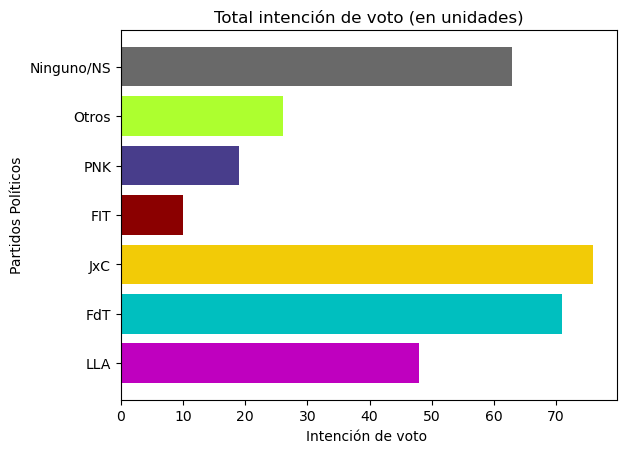

In [39]:
colores_partidos =["#BF00BF","#00BFBF","#F2CB07","#8B0000","#483D8B","#ADFF2F","#696969"]
partidos= ["LLA","FdT","JxC","FIT","PNK", "Otros","Ninguno/NS"]
valores= [LLA_total,FdT_total,JxC_total,FIT_total,PNK_total,Otros_total,Ninguno_NoSabe_total]
plt.barh(partidos, valores, color= colores_partidos)
plt.xlabel("Intención de voto ")
plt.ylabel("Partidos Políticos")
plt.title("Total intención de voto (en unidades)")
plt.show()

In [40]:
#Total de personas que intencionan votar a La Libertad Avanza por rango de edad
filtro1_LLA = (df["INT DE VOTO X ESPACIO"] == "LIBERTARIOS") & (df["EDAD"] == "16 a 25")
LLA_r1 = df[filtro1_LLA].shape[0] 
filtro2_LLA= (df["INT DE VOTO X ESPACIO"] == "LIBERTARIOS") & (df["EDAD"] == "26 a 35")
LLA_r2 = df[filtro2_LLA].shape[0] 
filtro3_LLA= (df["INT DE VOTO X ESPACIO"] == "LIBERTARIOS") & (df["EDAD"] == "36 a 45")
LLA_r3 = df[filtro3_LLA].shape[0]
filtro4_LLA= (df["INT DE VOTO X ESPACIO"] == "LIBERTARIOS") & (df["EDAD"] == "46 a 55")
LLA_r4 = df[filtro4_LLA].shape[0]
filtro5_LLA= (df["INT DE VOTO X ESPACIO"] == "LIBERTARIOS") & (df["EDAD"] == "56 y mas")
LLA_r5 = df[filtro5_LLA].shape[0]

print(f"{LLA_r1} personas de entre 16 y 25 años planean votar a La Libertad Avanza /n"
       f"{LLA_r2} personas de entre 26 a 35 años planean votar a La Libertad Avanza /n"
       f"{LLA_r3} personas de entre 36 a 45 años planean votar a La Libertad Avanza /n"
       f"{LLA_r4} personas de entre 46 a 55 años planean votar a La Libertad Avanza /n"
       f"{LLA_r5} personas de entre 56 y más años planean votar a La Libertad Avanza /n")


6 personas de entre 16 y 25 años planean votar a La Libertad Avanza /n7 personas de entre 26 a 35 años planean votar a La Libertad Avanza /n13 personas de entre 36 a 45 años planean votar a La Libertad Avanza /n10 personas de entre 46 a 55 años planean votar a La Libertad Avanza /n12 personas de entre 56 y más años planean votar a La Libertad Avanza /n


In [41]:
#Intención de voto de La Libertad Avanza por género

filtroV_LLA = (df["INT DE VOTO X ESPACIO"] == "LIBERTARIOS") & (df["GENERO"] == "Masculino")
LLA_varones = df[filtroV_LLA].shape[0] 

filtroM_LLA = (df["INT DE VOTO X ESPACIO"] == "LIBERTARIOS") & (df["GENERO"] == "Femenino")
LLA_mujeres = df[filtroM_LLA].shape[0] 

filtroO_LLA = (df["INT DE VOTO X ESPACIO"] == "LIBERTARIOS") & (df["GENERO"] == "Otro")
LLA_otros = df[filtroO_LLA].shape[0] 

print (f"{LLA_varones} hombres piensan votar a La Libertad Avanza /n"
       f"{LLA_mujeres} mujeres piensan votar a La Libertad Avanza /n"
       f"{LLA_otros} otros piensan votar a La Libertad Avanza /n")


39 hombres piensan votar a La Libertad Avanza /n8 mujeres piensan votar a La Libertad Avanza /n1 otros piensan votar a La Libertad Avanza /n


In [42]:
#Total de personas que intencionan votar al Frente de Todos por rango de edad
filtro1_FdT = (df["INT DE VOTO X ESPACIO"] == "FdT") & (df["EDAD"] == "16 a 25")
FdT_r1 = df[filtro1_FdT].shape[0] 

filtro2_FdT= (df["INT DE VOTO X ESPACIO"] == "FdT") & (df["EDAD"] == "26 a 35")
FdT_r2 = df[filtro2_FdT].shape[0] 

filtro3_FdT= (df["INT DE VOTO X ESPACIO"] == "FdT") & (df["EDAD"] == "36 a 45")
FdT_r3 = df[filtro3_FdT].shape[0]

filtro4_FdT= (df["INT DE VOTO X ESPACIO"] == "FdT") & (df["EDAD"] == "46 a 55")
FdT_r4 = df[filtro4_FdT].shape[0]

filtro5_FdT= (df["INT DE VOTO X ESPACIO"] == "FdT") & (df["EDAD"] == "56 y mas")
FdT_r5 = df[filtro5_FdT].shape[0]

print(f"{FdT_r1} personas de entre 16 y 25 años planean votar al Frente de Todos /n"
       f"{FdT_r2} personas de entre 26 a 35 años planean votar al Frente de Todos/n"
       f"{FdT_r3} personas de entre 36 a 45 años planean votar al Frente de Todos /n"
       f"{FdT_r4} personas de entre 46 a 55 años planean votar al Frente de Todos /n"
       f"{FdT_r5} personas de entre 56 y más años planean votar al Frente de Todos /n")

4 personas de entre 16 y 25 años planean votar al Frente de Todos /n12 personas de entre 26 a 35 años planean votar al Frente de Todos/n23 personas de entre 36 a 45 años planean votar al Frente de Todos /n9 personas de entre 46 a 55 años planean votar al Frente de Todos /n23 personas de entre 56 y más años planean votar al Frente de Todos /n


In [43]:
#Intención de voto del Frente de Todos por género
filtroV_FdT = (df["INT DE VOTO X ESPACIO"] == "FdT") & (df["GENERO"] == "Masculino")
FdT_varones = df[filtroV_FdT].shape[0] 

filtroM_FdT = (df["INT DE VOTO X ESPACIO"] == "FdT") & (df["GENERO"] == "Femenino")
FdT_mujeres = df[filtroM_FdT].shape[0] 

filtroO_FdT = (df["INT DE VOTO X ESPACIO"] == "FdT") & (df["GENERO"] == "Otro")
FdT_otros = df[filtroO_FdT].shape[0] 

print (f"{FdT_varones} hombres piensan votar al Frente de Todos /n"
       f"{FdT_mujeres} mujeres piensan votar al Frente de Todos/n"
       f"{FdT_otros} otros piensan votar al Frente de Todos /n")


41 hombres piensan votar al Frente de Todos /n30 mujeres piensan votar al Frente de Todos/n0 otros piensan votar al Frente de Todos /n


In [44]:
#Total de personas que intencionan votar a Juntos por el Cambio por rango de edad
filtro1_JxC = (df["INT DE VOTO X ESPACIO"] == "JxC") & (df["EDAD"] == "16 a 25")
JxC_r1 = df[filtro1_JxC].shape[0] 

filtro2_JxC = (df["INT DE VOTO X ESPACIO"] == "JxC") & (df["EDAD"] == "26 a 35")
JxC_r2 = df[filtro2_JxC].shape[0] 

filtro3_JxC = (df["INT DE VOTO X ESPACIO"] == "JxC") & (df["EDAD"] == "36 a 45")
JxC_r3 = df[filtro3_JxC].shape[0]

filtro4_JxC= (df["INT DE VOTO X ESPACIO"] == "JxC") & (df["EDAD"] == "46 a 55")
JxC_r4 = df[filtro4_JxC].shape[0]

filtro5_JxC= (df["INT DE VOTO X ESPACIO"] == "JxC") & (df["EDAD"] == "56 y mas")
JxC_r5 = df[filtro5_JxC].shape[0]

print(f"{JxC_r1} personas de entre 16 y 25 años planean votar a Juntos por el Cambio /n"
       f"{JxC_r2} personas de entre 26 a 35 años planean votara Juntos por el Cambio /n"
       f"{JxC_r3} personas de entre 36 a 45 años planean votar a Juntos por el Cambio /n"
       f"{JxC_r4} personas de entre 46 a 55 años planean votar a Juntos por el Cambio /n"
       f"{JxC_r5} personas de entre 56 y más años planean votar a Juntos por el Cambio /n")

5 personas de entre 16 y 25 años planean votar a Juntos por el Cambio /n8 personas de entre 26 a 35 años planean votara Juntos por el Cambio /n20 personas de entre 36 a 45 años planean votar a Juntos por el Cambio /n18 personas de entre 46 a 55 años planean votar a Juntos por el Cambio /n25 personas de entre 56 y más años planean votar a Juntos por el Cambio /n


In [45]:
#Intención de voto de Juntos por el Cambio por género
filtroV_JxC = (df["INT DE VOTO X ESPACIO"] == "JxC") & (df["GENERO"] == "Masculino")
JxC_varones = df[filtroV_JxC].shape[0] 

filtroM_JxC = (df["INT DE VOTO X ESPACIO"] == "JxC") & (df["GENERO"] == "Femenino")
JxC_mujeres = df[filtroM_JxC].shape[0] 

filtroO_JxC = (df["INT DE VOTO X ESPACIO"] == "JxC") & (df["GENERO"] == "Otro")
JxC_otros = df[filtroO_JxC].shape[0] 

print (f"{JxC_varones} hombres piensan votar a Juntos por el Cambio /n"
       f"{JxC_mujeres} mujeres piensan votar a Juntos por el Cambio /n"
       f"{JxC_otros} otros piensan votar a Juntos por el Cambio /n")

39 hombres piensan votar a Juntos por el Cambio /n37 mujeres piensan votar a Juntos por el Cambio /n0 otros piensan votar a Juntos por el Cambio /n


In [46]:
#Total de personas que intencionan votar al Frente de Izquierda por rango de edad
filtro1_FIT = (df["INT DE VOTO X ESPACIO"] == "FIT") & (df["EDAD"] == "16 a 25")
FIT_r1 = df[filtro1_FIT].shape[0] 

filtro2_FIT = (df["INT DE VOTO X ESPACIO"] == "FIT") & (df["EDAD"] == "26 a 35")
FIT_r2 = df[filtro2_FIT].shape[0] 

filtro3_FIT = (df["INT DE VOTO X ESPACIO"] == "FIT") & (df["EDAD"] == "36 a 45")
FIT_r3 = df[filtro3_FIT].shape[0]

filtro4_FIT= (df["INT DE VOTO X ESPACIO"] == "FIT") & (df["EDAD"] == "46 a 55")
FIT_r4 = df[filtro4_FIT].shape[0]

filtro5_FIT= (df["INT DE VOTO X ESPACIO"] == "FIT") & (df["EDAD"] == "56 y mas")
FIT_r5 = df[filtro5_FIT].shape[0]

print(f"{FIT_r1} personas de entre 16 y 25 años planean votar al Frente de Izquierda /n"
       f"{FIT_r2} personas de entre 26 a 35 años planean votar al Frente de Izquierda /n"
       f"{FIT_r3} personas de entre 36 a 45 años planean votar al Frente de Izquierda /n"
       f"{FIT_r4} personas de entre 46 a 55 años planean votar al Frente de Izquierda /n"
       f"{FIT_r5} personas de entre 56 y más años planean votar al Frente de Izquierda /n")




1 personas de entre 16 y 25 años planean votar al Frente de Izquierda /n3 personas de entre 26 a 35 años planean votar al Frente de Izquierda /n4 personas de entre 36 a 45 años planean votar al Frente de Izquierda /n1 personas de entre 46 a 55 años planean votar al Frente de Izquierda /n1 personas de entre 56 y más años planean votar al Frente de Izquierda /n


In [47]:
#Intención de voto del Frente de Izquierda por género
filtroV_FIT = (df["INT DE VOTO X ESPACIO"] == "FIT") & (df["GENERO"] == "Masculino")
FIT_varones = df[filtroV_FIT].shape[0] 

filtroM_FIT = (df["INT DE VOTO X ESPACIO"] == "FIT") & (df["GENERO"] == "Femenino")
FIT_mujeres = df[filtroM_FIT].shape[0] 

filtroO_FIT = (df["INT DE VOTO X ESPACIO"] == "FIT") & (df["GENERO"] == "Otro")
FIT_otros = df[filtroO_FIT].shape[0] 

print (f"{FIT_varones} hombres piensan votar al Frente de Izquierda /n"
       f"{FIT_mujeres} mujeres piensan votar al Frente de Izquierda /n"
       f"{FIT_otros} otros piensan votar al Frente de Izquierda /n")

4 hombres piensan votar al Frente de Izquierda /n4 mujeres piensan votar al Frente de Izquierda /n2 otros piensan votar al Frente de Izquierda /n


In [48]:
#Total de personas que intencionan votar al Peronismo No Kircherista por rango de edad
filtro1_PNK = (df["INT DE VOTO X ESPACIO"] == "PNK") & (df["EDAD"] == "16 a 25")
PNK_r1 = df[filtro1_PNK].shape[0] 

filtro2_PNK = (df["INT DE VOTO X ESPACIO"] == "PNK") & (df["EDAD"] == "26 a 35")
PNK_r2 = df[filtro2_PNK].shape[0] 

filtro3_PNK = (df["INT DE VOTO X ESPACIO"] == "PNK") & (df["EDAD"] == "36 a 45")
PNK_r3 = df[filtro3_PNK].shape[0]

filtro4_PNK= (df["INT DE VOTO X ESPACIO"] == "PNK") & (df["EDAD"] == "46 a 55")
PNK_r4 = df[filtro4_PNK].shape[0]

filtro5_PNK= (df["INT DE VOTO X ESPACIO"] == "PNK") & (df["EDAD"] == "56 y mas")
PNK_r5 = df[filtro5_PNK].shape[0]

print(f"{PNK_r1} personas de entre 16 y 25 años planean votar al Peronismo No Kircherista /n"
       f"{PNK_r2} personas de entre 26 a 35 años planean votar al Peronismo No Kircherista /n"
       f"{PNK_r3} personas de entre 36 a 45 años planean votar al Peronismo No Kircherista /n"
       f"{PNK_r4} personas de entre 46 a 55 años planean votar al Peronismo No Kircherista /n"
       f"{PNK_r5} personas de entre 56 y más años planean votar al Peronismo No Kircherista /n")

0 personas de entre 16 y 25 años planean votar al Peronismo No Kircherista /n4 personas de entre 26 a 35 años planean votar al Peronismo No Kircherista /n7 personas de entre 36 a 45 años planean votar al Peronismo No Kircherista /n2 personas de entre 46 a 55 años planean votar al Peronismo No Kircherista /n6 personas de entre 56 y más años planean votar al Peronismo No Kircherista /n


In [49]:
#Intención de voto del Peronismo No Kirchnerista por género
filtroV_PNK = (df["INT DE VOTO X ESPACIO"] == "PNK") & (df["GENERO"] == "Masculino")
PNK_varones = df[filtroV_PNK].shape[0] 

filtroM_PNK = (df["INT DE VOTO X ESPACIO"] == "PNK") & (df["GENERO"] == "Femenino")
PNK_mujeres = df[filtroM_PNK].shape[0] 

filtroO_PNK = (df["INT DE VOTO X ESPACIO"] == "PNK") & (df["GENERO"] == "Otro")
PNK_otros = df[filtroO_PNK].shape[0] 

print (f"{PNK_varones} hombres piensan votar al Peronismo No Kirchnerista /n"
       f"{PNK_mujeres} mujeres piensan votar al Peronismo No Kirchnerista /n"
       f"{PNK_otros} otros piensan votar al Peronismo No Kirchnerista /n")


10 hombres piensan votar al Peronismo No Kirchnerista /n9 mujeres piensan votar al Peronismo No Kirchnerista /n0 otros piensan votar al Peronismo No Kirchnerista /n


In [50]:
#Total de personas que intencionan votar a Otros por rango de edad
filtro1_Otros = (df["INT DE VOTO X ESPACIO"] == "OTROS") & (df["EDAD"] == "16 a 25")
Otros_r1 = df[filtro1_Otros].shape[0] 

filtro2_Otros = (df["INT DE VOTO X ESPACIO"] == "OTROS") & (df["EDAD"] == "26 a 35")
Otros_r2 = df[filtro2_Otros].shape[0] 

filtro3_Otros = (df["INT DE VOTO X ESPACIO"] == "OTROS") & (df["EDAD"] == "36 a 45")
Otros_r3 = df[filtro3_Otros].shape[0]

filtro4_Otros= (df["INT DE VOTO X ESPACIO"] == "OTROS") & (df["EDAD"] == "46 a 55")
Otros_r4 = df[filtro4_Otros].shape[0]

filtro5_Otros= (df["INT DE VOTO X ESPACIO"] == "OTROS") & (df["EDAD"] == "56 y mas")
Otros_r5 = df[filtro5_Otros].shape[0]

print(f"{Otros_r1} personas de entre 16 y 25 años planean votar a Otros /n"
       f"{Otros_r2} personas de entre 26 a 35 años planean votar a Otros /n"
       f"{Otros_r3} personas de entre 36 a 45 años planean votar a Otros /n"
       f"{Otros_r4} personas de entre 46 a 55 años planean votar a Otros /n"
       f"{Otros_r5} personas de entre 56 y más años planean votar a Otros /n")

0 personas de entre 16 y 25 años planean votar a Otros /n4 personas de entre 26 a 35 años planean votar a Otros /n6 personas de entre 36 a 45 años planean votar a Otros /n12 personas de entre 46 a 55 años planean votar a Otros /n4 personas de entre 56 y más años planean votar a Otros /n


In [51]:
#Intención de voto de Otros por género
filtroV_Otros = (df["INT DE VOTO X ESPACIO"] == "OTROS") & (df["GENERO"] == "Masculino")
Otros_varones = df[filtroV_Otros].shape[0] 

filtroM_Otros = (df["INT DE VOTO X ESPACIO"] == "OTROS") & (df["GENERO"] == "Femenino")
Otros_mujeres = df[filtroM_Otros].shape[0] 

filtroO_Otros = (df["INT DE VOTO X ESPACIO"] == "OTROS") & (df["GENERO"] == "Otro")
Otros_otros = df[filtroO_Otros].shape[0] 

print(f"{Otros_varones} hombres piensan votar a Otros /n"
       f"{Otros_mujeres} mujeres piensan votar a Otros /n"
       f"{Otros_otros} otros piensan votar a Otros /n")

11 hombres piensan votar a Otros /n14 mujeres piensan votar a Otros /n1 otros piensan votar a Otros /n


In [52]:
#Total de personas que intencionan no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán
filtro1_Ninguno_NoSabe = (df["INT DE VOTO X ESPACIO"] == "NINGUNO/NOSABE") & (df["EDAD"] == "16 a 25")
Ninguno_NoSabe_r1 = df[filtro1_Ninguno_NoSabe].shape[0] 

filtro2_Ninguno_NoSabe = (df["INT DE VOTO X ESPACIO"] == "NINGUNO/NOSABE") & (df["EDAD"] == "26 a 35")
Ninguno_NoSabe_r2 = df[filtro2_Ninguno_NoSabe].shape[0] 

filtro3_Ninguno_NoSabe = (df["INT DE VOTO X ESPACIO"] == "NINGUNO/NOSABE") & (df["EDAD"] == "36 a 45")
Ninguno_NoSabe_r3 = df[filtro3_Ninguno_NoSabe].shape[0]

filtro4_Ninguno_NoSabe= (df["INT DE VOTO X ESPACIO"] == "NINGUNO/NOSABE") & (df["EDAD"] == "46 a 55")
Ninguno_NoSabe_r4 = df[filtro4_Ninguno_NoSabe].shape[0]

filtro5_Ninguno_NoSabe= (df["INT DE VOTO X ESPACIO"] == "NINGUNO/NOSABE") & (df["EDAD"] == "56 y mas")
Ninguno_NoSabe_r5 = df[filtro5_Ninguno_NoSabe].shape[0]

print(f"{Ninguno_NoSabe_r1} personas de entre 16 y 25 años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n"
       f"{Ninguno_NoSabe_r2} personas de entre 26 a 35 años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n"
       f"{Ninguno_NoSabe_r3} personas de entre 36 a 45 años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n"
       f"{Ninguno_NoSabe_r4} personas de entre 46 a 55 años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n"
       f"{Ninguno_NoSabe_r5} personas de entre 56 y más años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n")


4 personas de entre 16 y 25 años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n11 personas de entre 26 a 35 años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n15 personas de entre 36 a 45 años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n18 personas de entre 46 a 55 años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n15 personas de entre 56 y más años planean no votar a ninguno de los partidos polítiicos mencionados o aún saben a cuál votarán /n


In [53]:
#Intención de no votar a ninguno de ellos por género
filtroV_Ninguno_NoSabe = (df["INT DE VOTO X ESPACIO"] == "NINGUNO/NOSABE") & (df["GENERO"] == "Masculino")
Ninguno_NoSabe_varones = df[filtroV_Ninguno_NoSabe].shape[0] 

filtroM_Ninguno_NoSabe = (df["INT DE VOTO X ESPACIO"] == "NINGUNO/NOSABE") & (df["GENERO"] == "Femenino")
Ninguno_NoSabe_mujeres = df[filtroM_Ninguno_NoSabe].shape[0] 

filtroO_Ninguno_NoSabe = (df["INT DE VOTO X ESPACIO"] == "NINGUNO/NOSABE") & (df["GENERO"] == "Otro")
Ninguno_NoSabe_otros = df[filtroO_Ninguno_NoSabe].shape[0] 

print(f"{Ninguno_NoSabe_varones} hombres piensan no votar a ninguno de ellos /n"
       f"{Ninguno_NoSabe_mujeres} mujeres piensan no votar a ninguno de ellos /n"
       f"{Ninguno_NoSabe_otros} otros piensan no votar a ninguno de ellos /n")

24 hombres piensan no votar a ninguno de ellos /n37 mujeres piensan no votar a ninguno de ellos /n2 otros piensan no votar a ninguno de ellos /n


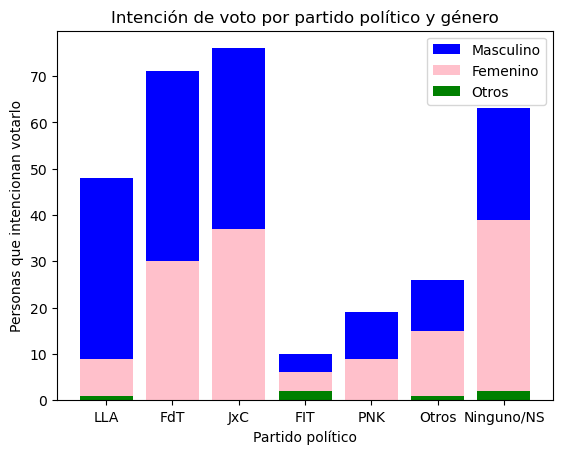

In [54]:
#Gráfico de barras
data= pd.DataFrame({"Masculino": [LLA_varones, FdT_varones,JxC_varones,FIT_varones,PNK_varones,Otros_varones, Ninguno_NoSabe_varones],
                     "Femenino" : [LLA_mujeres,FdT_mujeres,JxC_mujeres,FIT_mujeres,PNK_mujeres,Otros_mujeres, Ninguno_NoSabe_mujeres],
                     "Otros": [LLA_otros,FdT_otros,JxC_otros,FIT_otros, PNK_otros,Otros_otros, Ninguno_NoSabe_otros]},
                     index= ("LLA","FdT","JxC","FIT","PNK", "Otros","Ninguno/NS"))
total = data.sum(axis=1)
plt.bar(data.index, data.Masculino + data.Femenino + data.Otros, label= "Masculino", color="blue")
plt.bar(data.index, data.Femenino + data.Otros, label= "Femenino", color="pink")
plt.bar(data.index, data.Otros, label= "Otros", color= "green")
plt.legend(loc='best')
plt.title("Intención de voto por partido político y género")
plt.xlabel ("Partido político")
plt.ylabel ("Personas que intencionan votarlo")
plt.show()


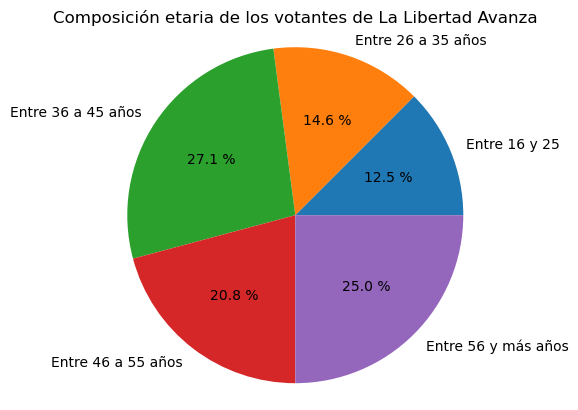

In [55]:
#Gráfico de torta, rango etario votantes de LLA
votantesLLA = [LLA_r1,LLA_r2,LLA_r3,LLA_r4,LLA_r5]
categorias = ["Entre 16 y 25", "Entre 26 a 35 años", "Entre 36 a 45 años", "Entre 46 a 55 años", "Entre 56 y más años" ]
plt.pie (votantesLLA, labels=categorias,autopct="%0.1f %%")
plt.axis("equal")
plt.title("Composición etaria de los votantes de La Libertad Avanza")
plt.show()

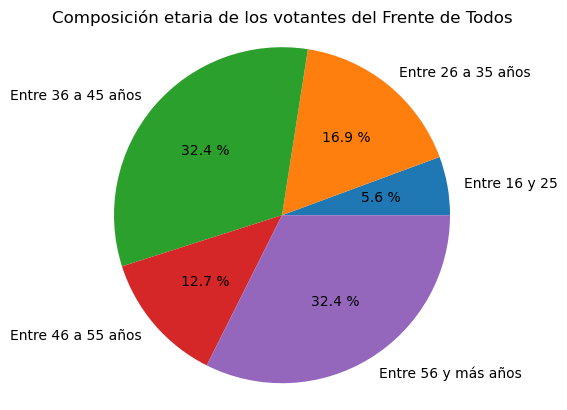

In [56]:
#Gráfico de torta, rango etario votantes del Fdt
votantesFdT = [FdT_r1,FdT_r2,FdT_r3,FdT_r4,FdT_r5]
categorias = ["Entre 16 y 25", "Entre 26 a 35 años", "Entre 36 a 45 años", "Entre 46 a 55 años", "Entre 56 y más años" ]
plt.pie (votantesFdT, labels=categorias,autopct="%0.1f %%")
plt.axis("equal")
plt.title("Composición etaria de los votantes del Frente de Todos")
plt.show()


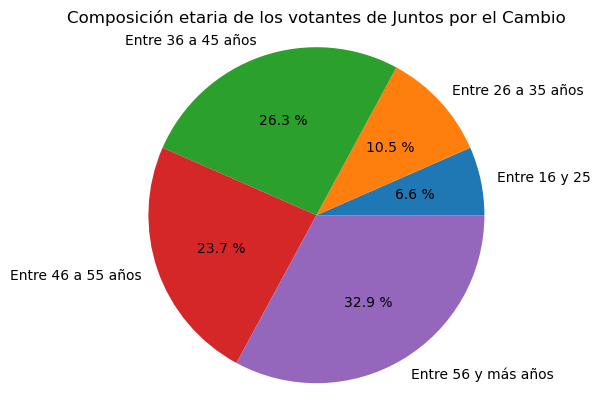

In [57]:
#Gráfico de torta, rango etario votantes de JxC
votantesJxC = [JxC_r1,JxC_r2,JxC_r3,JxC_r4,JxC_r5]
categorias = ["Entre 16 y 25", "Entre 26 a 35 años", "Entre 36 a 45 años", "Entre 46 a 55 años", "Entre 56 y más años" ]
plt.pie (votantesJxC, labels=categorias,autopct="%0.1f %%")
plt.axis("equal")
plt.title("Composición etaria de los votantes de Juntos por el Cambio")
plt.show()

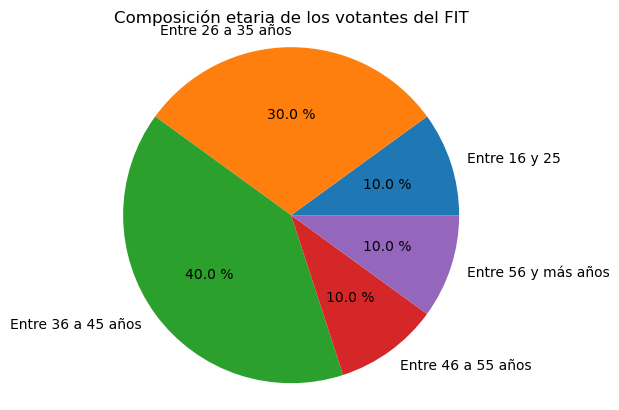

In [58]:
#Gráfico de torta, rango etario votantes del FIT
votantesFIT = [FIT_r1,FIT_r2,FIT_r3,FIT_r4,FIT_r5]
categorias = ["Entre 16 y 25", "Entre 26 a 35 años", "Entre 36 a 45 años", "Entre 46 a 55 años", "Entre 56 y más años" ]
plt.pie (votantesFIT, labels=categorias,autopct="%0.1f %%")
plt.axis("equal")
plt.title("Composición etaria de los votantes del FIT")
plt.show()

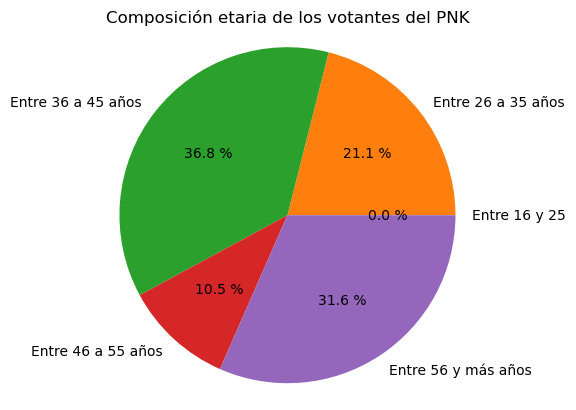

In [59]:
#Gráfico de torta, rango etario votantes del PNK
votantesPNK = [PNK_r1,PNK_r2,PNK_r3,PNK_r4,PNK_r5]
categorias = ["Entre 16 y 25", "Entre 26 a 35 años", "Entre 36 a 45 años", "Entre 46 a 55 años", "Entre 56 y más años" ]
plt.pie (votantesPNK, labels=categorias,autopct="%0.1f %%")
plt.axis("equal")
plt.title("Composición etaria de los votantes del PNK")
plt.show()

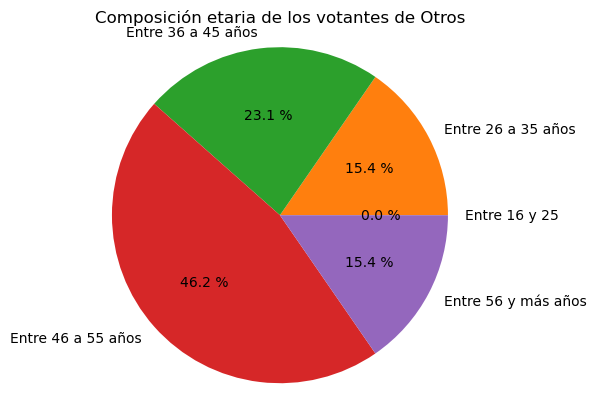

In [60]:
#Gráfico de torta, rango etario votantes de Otros
votantesOtros = [Otros_r1,Otros_r2,Otros_r3,Otros_r4,Otros_r5]
categorias = ["Entre 16 y 25", "Entre 26 a 35 años", "Entre 36 a 45 años", "Entre 46 a 55 años", "Entre 56 y más años" ]
plt.pie (votantesOtros, labels=categorias,autopct="%0.1f %%")
plt.axis("equal")
plt.title("Composición etaria de los votantes de Otros")
plt.show()

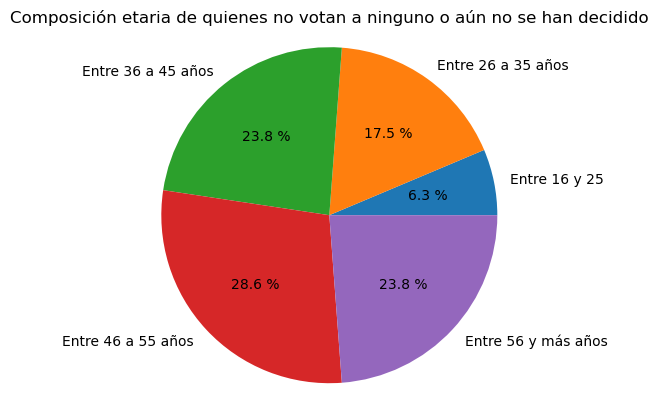

In [61]:
#Gráfico de torta, rango etario de quienes no votan a ninguno o aún no se han decidido
votantesNinguno_NoSabe = [Ninguno_NoSabe_r1,Ninguno_NoSabe_r2,Ninguno_NoSabe_r3,Ninguno_NoSabe_r4,Ninguno_NoSabe_r5]
categorias = ["Entre 16 y 25", "Entre 26 a 35 años", "Entre 36 a 45 años", "Entre 46 a 55 años", "Entre 56 y más años" ]
plt.pie (votantesNinguno_NoSabe, labels=categorias,autopct="%0.1f %%")
plt.axis("equal")
plt.title("Composición etaria de quienes no votan a ninguno o aún no se han decidido")
plt.show()

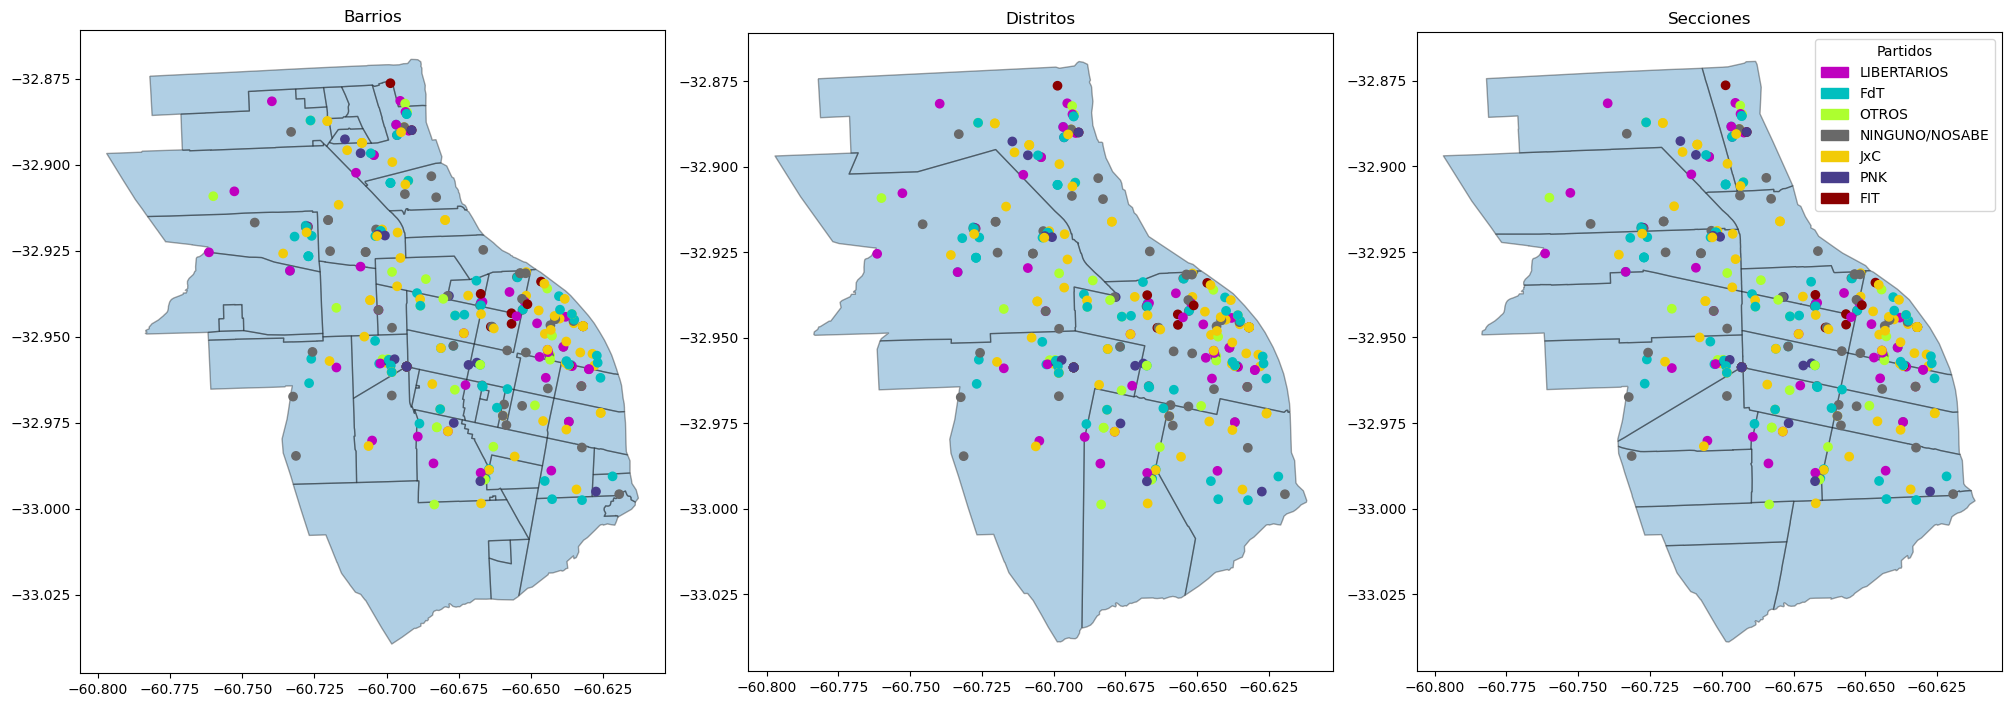

In [63]:
colores_partidos = {
    'LIBERTARIOS': '#BF00BF',
    'FdT': '#00BFBF',
    'OTROS': '#ADFF2F',
    'NINGUNO/NOSABE': '#696969',
    'JxC': '#F2CB07',
    'PNK': '#483D8B',
    'FIT': '#8B0000',
}
fig, axes = plt.subplots(1, 3, figsize=(20, 10), constrained_layout=True)
base = barrios.plot(figsize=(20, 20), alpha=0.35, edgecolor='k', ax=axes[0])
gdf.plot(ax=base, color=gdf['color'])
axes[0].set_title('Barrios')
base = distritos.plot(figsize=(20, 20), alpha=0.35, edgecolor='k', ax=axes[1])
gdf.plot(ax=base, color=gdf['color'])
axes[1].set_title('Distritos')
base = secciones.plot(figsize=(20, 20), alpha=0.35, edgecolor='k', ax=axes[2])
gdf.plot(ax=base, legend=True, color=gdf['color'])
axes[2].set_title('Secciones')
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]

plt.legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
plt.show()

In [64]:
conteo_votos = (
    union.groupby(['BARRIO', 'INT DE VOTO X ESPACIO'])
    .size()
    .reset_index(name='conteo')
)
mayor_votos_por_barrio = conteo_votos.loc[conteo_votos.groupby('BARRIO')['conteo'].idxmax()]
barrios = barrios.merge(mayor_votos_por_barrio, on='BARRIO', how='left')
barrios['color'] = barrios['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')
conteo_votos_por_barrio = (
    union.groupby('BARRIO')
    .size()
    .reset_index(name='cantidad_votos')
)
barrios = barrios.merge(conteo_votos_por_barrio, on='BARRIO', how='left')

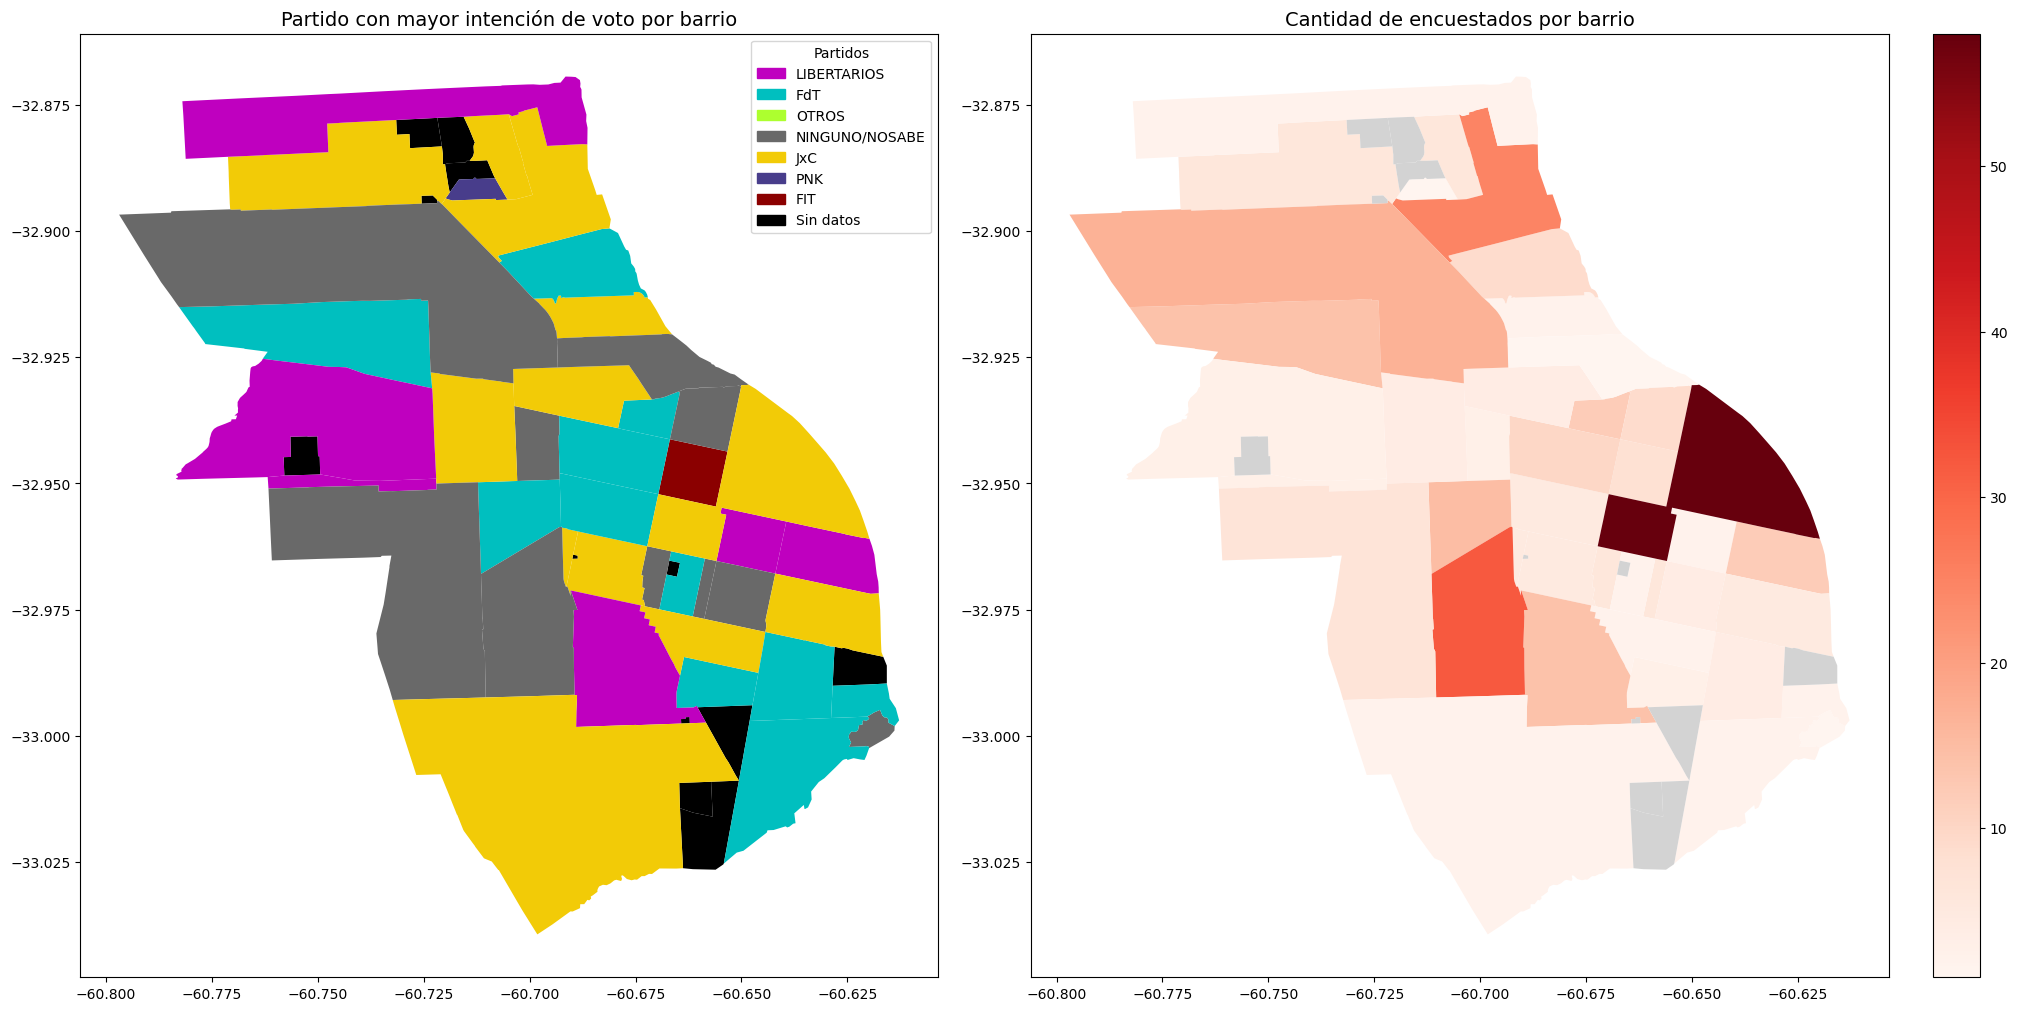

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
barrios.plot(color=barrios['color'], ax=axes[0])
axes[0].set_title('Partido con mayor intención de voto por barrio', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[0].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
barrios.plot(
    column='cantidad_votos', 
    cmap='Reds', 
    legend=True, 
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
    }
)
axes[1].set_title('Cantidad de encuestados por barrio', fontsize=14)
plt.show()

In [66]:
conteo_votos = (
    uniondistritos.groupby(['DISTRITO', 'INT DE VOTO X ESPACIO'])
    .size()
    .reset_index(name='conteo')
)
mayor_votos_por_distrito = conteo_votos.loc[conteo_votos.groupby('DISTRITO')['conteo'].idxmax()]
distritos = distritos.merge(mayor_votos_por_distrito, on='DISTRITO', how='left')
distritos['color'] = distritos['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')
conteo_votos_por_distrito = (
    uniondistritos.groupby('DISTRITO')
    .size()
    .reset_index(name='cantidad_votos')
)
distritos = distritos.merge(conteo_votos_por_distrito, on='DISTRITO', how='left')

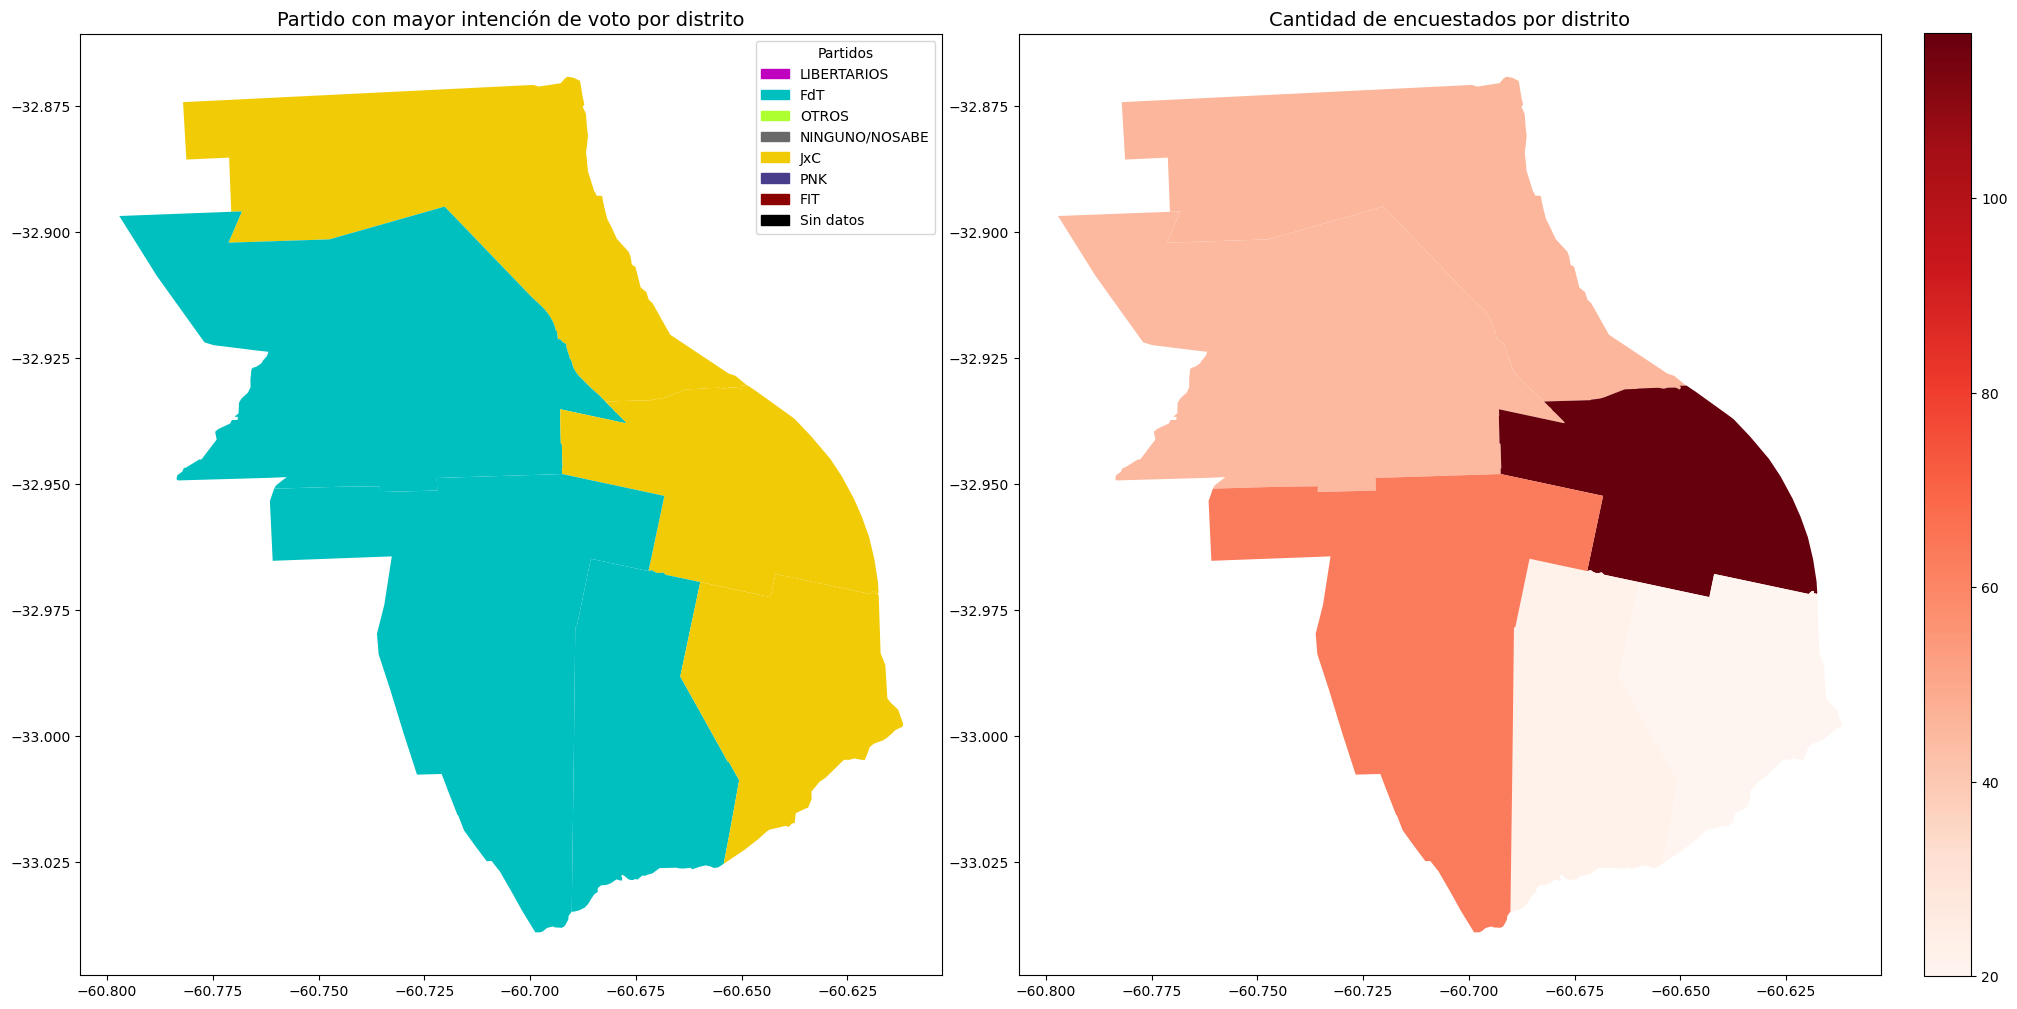

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
distritos.plot(color=distritos['color'], ax=axes[0])
axes[0].set_title('Partido con mayor intención de voto por distrito', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[0].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
distritos.plot(
    column='cantidad_votos', 
    cmap='Reds', 
    legend=True, 
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos"}
)
axes[1].set_title('Cantidad de encuestados por distrito', fontsize=14)
plt.show()

In [68]:
conteo_votos = (
    unionseccion.groupby(['SECCION', 'INT DE VOTO X ESPACIO'])
    .size()
    .reset_index(name='conteo')
)
mayor_votos_por_seccion = conteo_votos.loc[conteo_votos.groupby('SECCION')['conteo'].idxmax()]
secciones = secciones.merge(mayor_votos_por_seccion, on='SECCION', how='left')
secciones['color'] = secciones['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')
conteo_votos_por_secciones = (
    unionseccion.groupby('SECCION')
    .size()
    .reset_index(name='cantidad_votos')
)
secciones = secciones.merge(conteo_votos_por_secciones, on='SECCION', how='left')

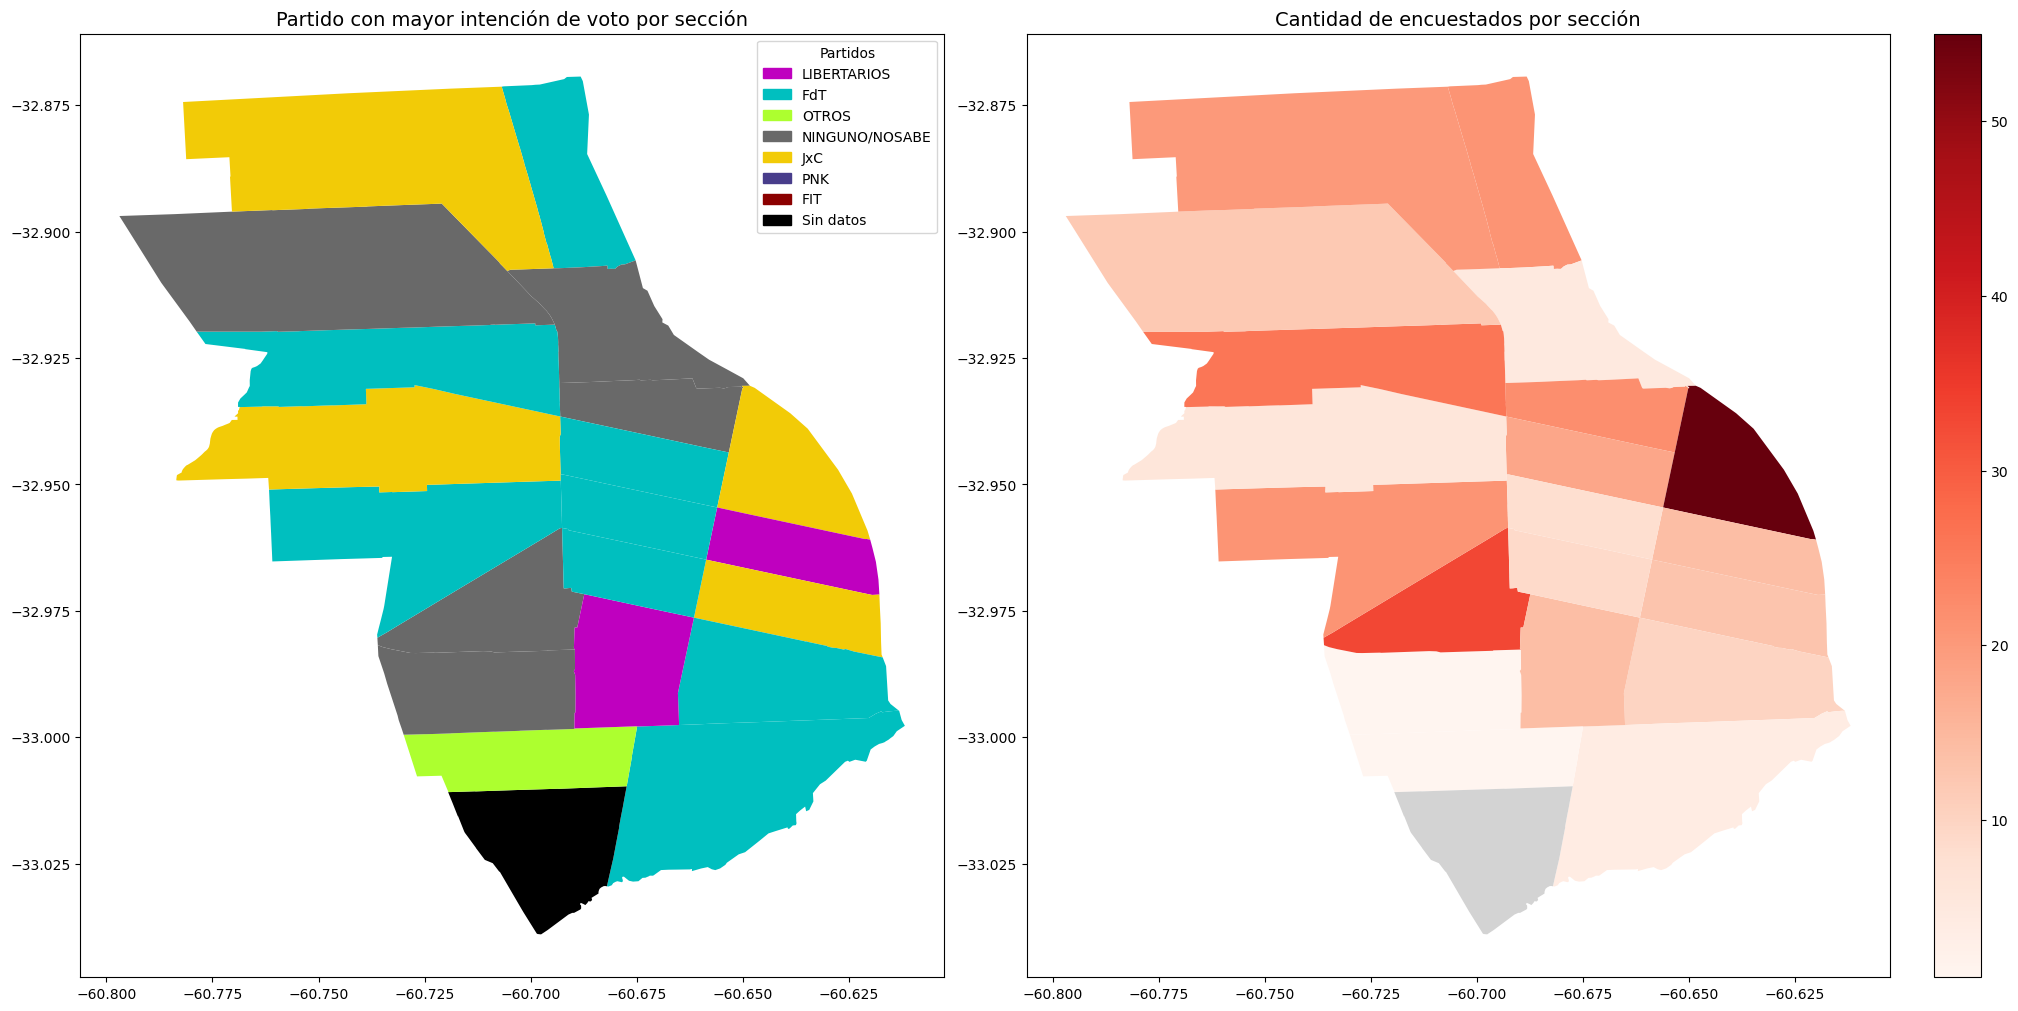

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
secciones.plot(color=secciones['color'], ax=axes[0])
axes[0].set_title('Partido con mayor intención de voto por sección', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[0].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
secciones.plot(
    column='cantidad_votos', 
    cmap='Reds', 
    legend=True, 
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos"}
)
axes[1].set_title('Cantidad de encuestados por sección', fontsize=14)
plt.show()

In [70]:
gdf_votos_fdt=union[union['INT DE VOTO X ESPACIO']=='FdT']
conteo_votos_fdt = gdf_votos_fdt.groupby('BARRIO').size().reset_index(name='cantidad_votos_fdt')
barrios = barrios.merge(conteo_votos_fdt, on='BARRIO', how='left')

In [71]:
gdf_votos_fdt_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='FdT']
conteo_votos_fdt_dis = gdf_votos_fdt_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_fdt')
distritos = distritos.merge(conteo_votos_fdt_dis, on='DISTRITO', how='left')

In [72]:
gdf_votos_fdt_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='FdT']
conteo_votos_fdt_sec = gdf_votos_fdt_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_fdt')
secciones = secciones.merge(conteo_votos_fdt_sec, on='SECCION', how='left')

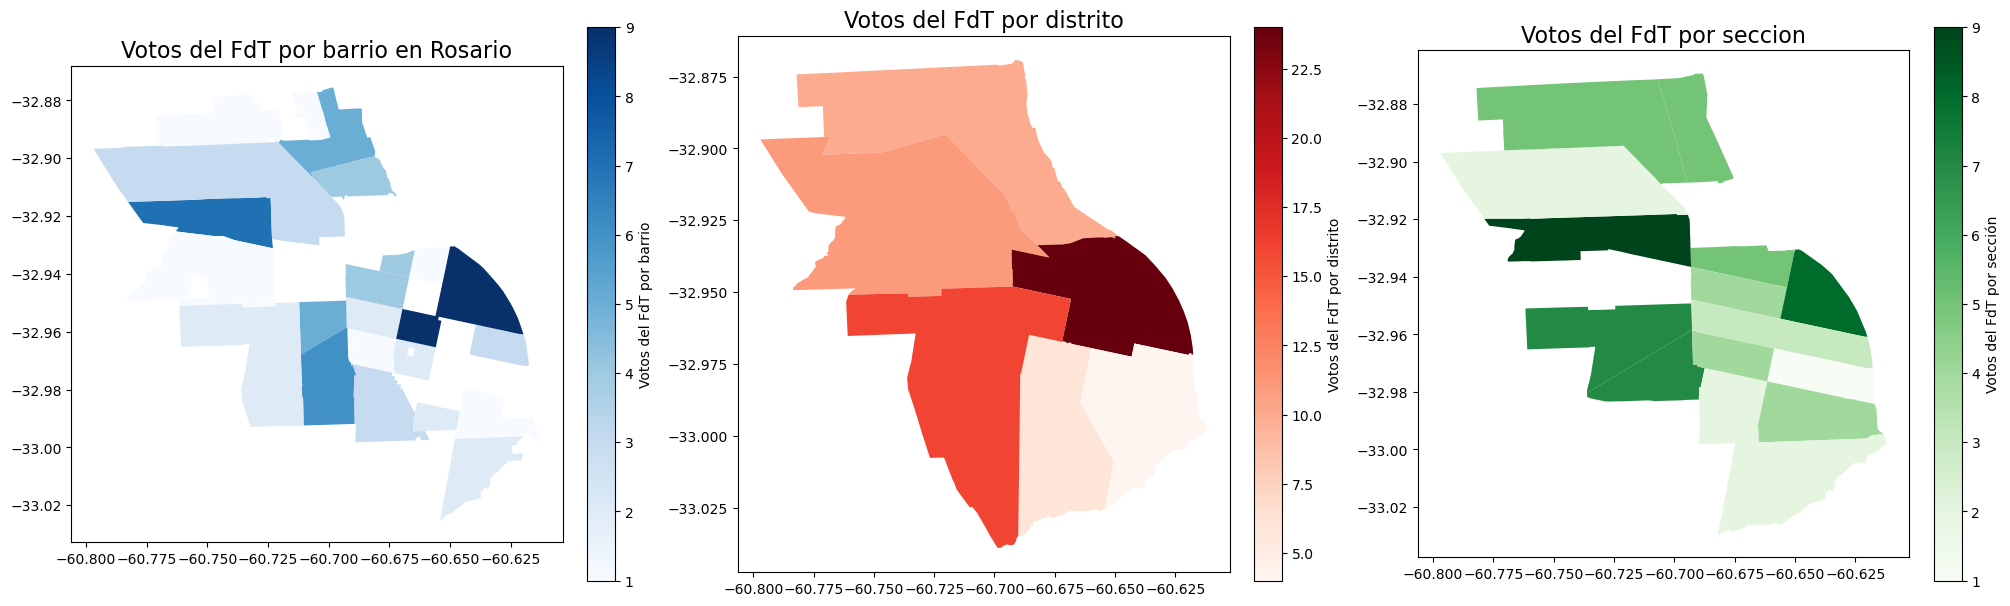

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_fdt', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del FdT por barrio",'shrink': 0.8})
axes[0].set_title('Votos del FdT por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_fdt', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos del FdT por distrito', 'shrink': 0.8})
axes[1].set_title('Votos del FdT por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_fdt', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos del FdT por sección', 'shrink': 0.8})
axes[2].set_title('Votos del FdT por seccion', fontsize=16)
plt.show()

In [74]:
gdf_votos_jxc=union[union['INT DE VOTO X ESPACIO']=='JxC']
conteo_votos_jxc = gdf_votos_jxc.groupby('BARRIO').size().reset_index(name='cantidad_votos_jxc')
barrios = barrios.merge(conteo_votos_jxc, on='BARRIO', how='left')
gdf_votos_jxc_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='JxC']
conteo_votos_jxc_dis = gdf_votos_jxc_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_jxc')
distritos = distritos.merge(conteo_votos_jxc_dis, on='DISTRITO', how='left')
gdf_votos_jxc_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='JxC']
conteo_votos_jxc_sec = gdf_votos_jxc_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_jxc')
secciones = secciones.merge(conteo_votos_jxc_sec, on='SECCION', how='left')

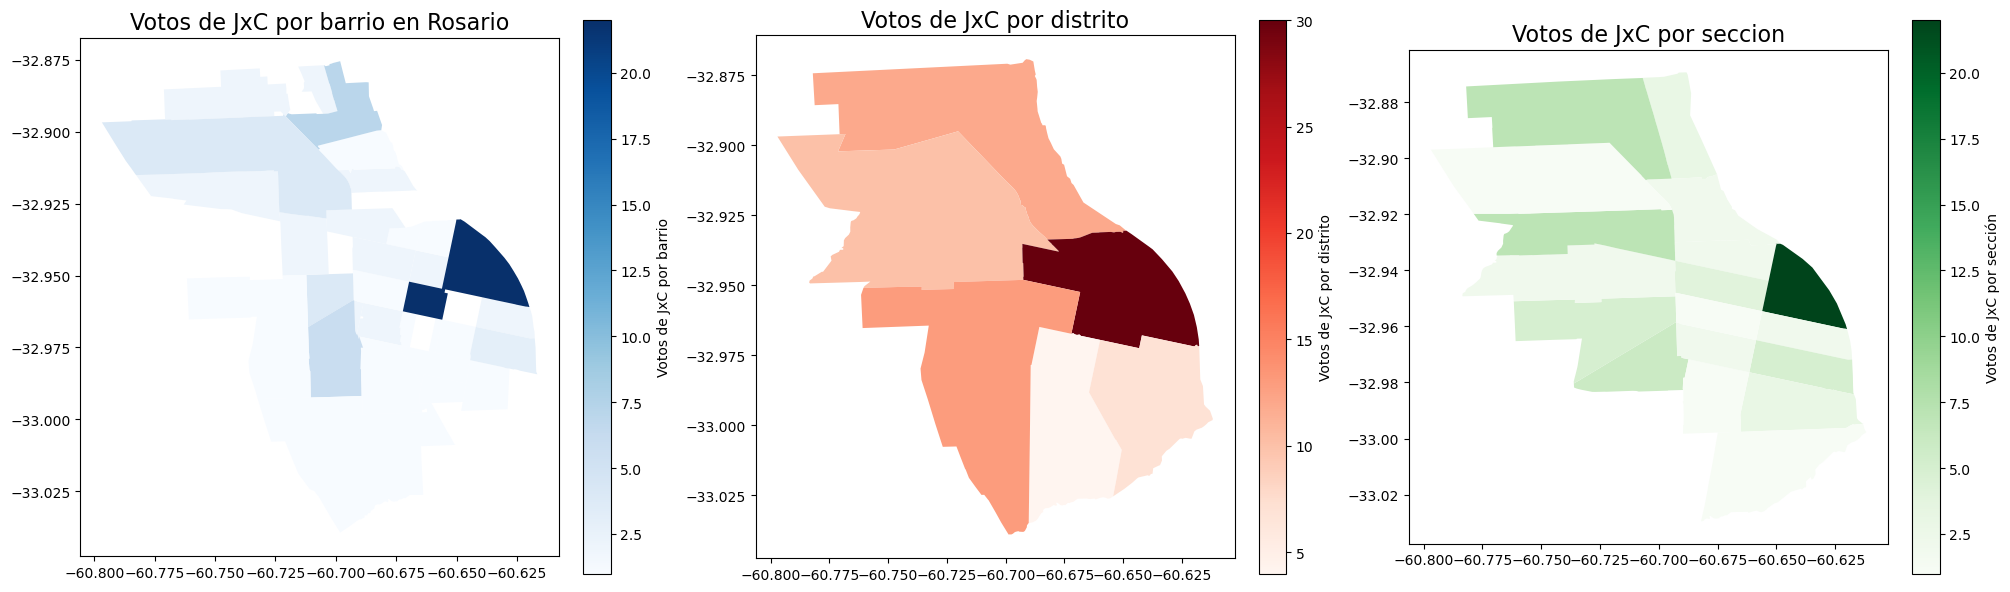

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_jxc', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos de JxC por barrio", 'shrink': 0.8})
axes[0].set_title('Votos de JxC por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_jxc', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos de JxC por distrito', 'shrink': 0.8})
axes[1].set_title('Votos de JxC por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_jxc', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos de JxC por sección', 'shrink': 0.8})
axes[2].set_title('Votos de JxC por seccion', fontsize=16)
plt.show()

In [76]:
gdf_votos_lib=union[union['INT DE VOTO X ESPACIO']=='LIBERTARIOS']
conteo_votos_lib = gdf_votos_lib.groupby('BARRIO').size().reset_index(name='cantidad_votos_lib')
barrios = barrios.merge(conteo_votos_lib, on='BARRIO', how='left')
gdf_votos_lib_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='LIBERTARIOS']
conteo_votos_lib_dis = gdf_votos_lib_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_lib')
distritos = distritos.merge(conteo_votos_lib_dis, on='DISTRITO', how='left')
gdf_votos_lib_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='LIBERTARIOS']
conteo_votos_lib_sec = gdf_votos_lib_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_lib')
secciones = secciones.merge(conteo_votos_lib_sec, on='SECCION', how='left')

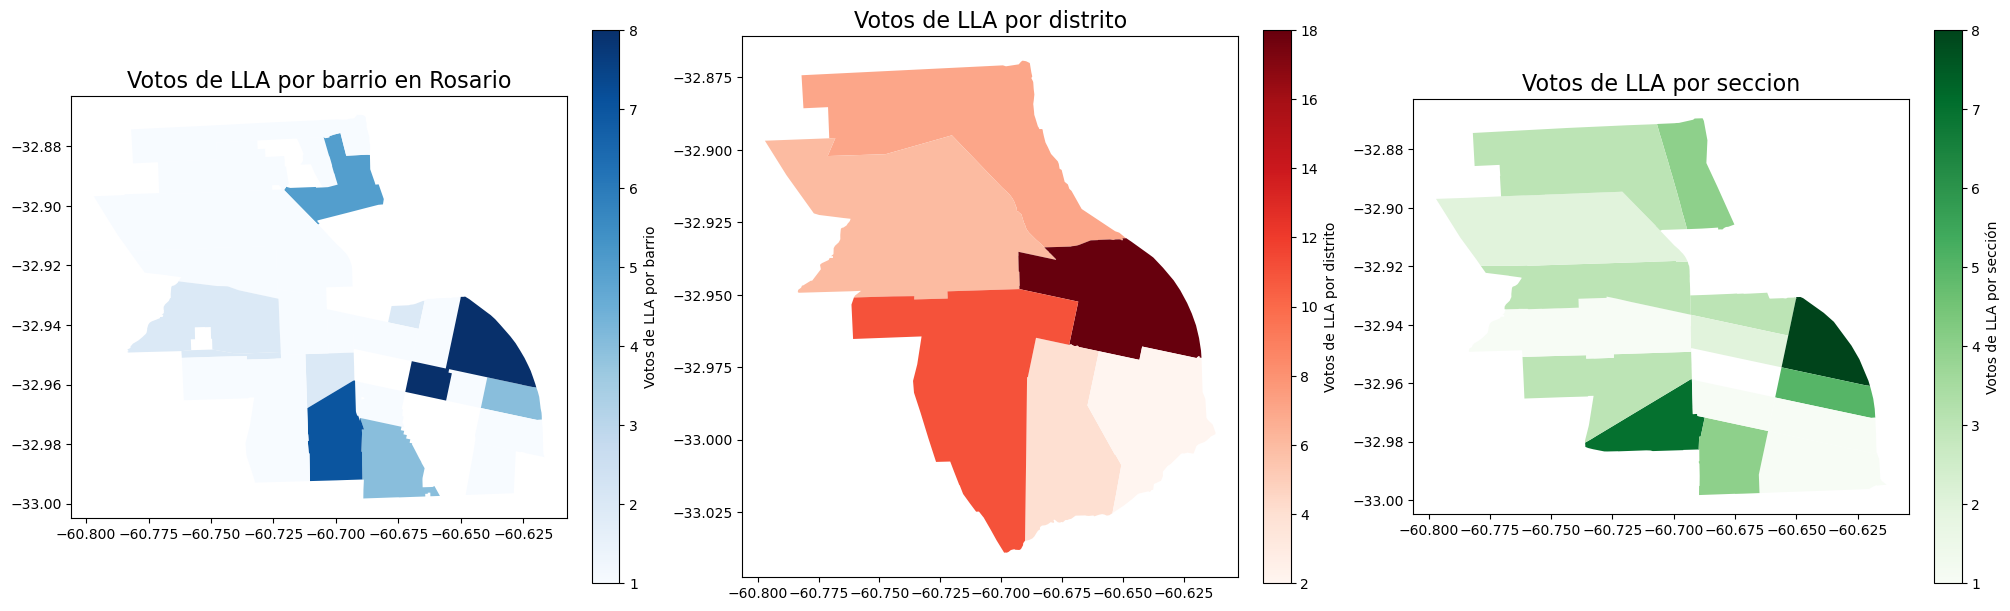

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_lib', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos de LLA por barrio", 'shrink': 0.8})
axes[0].set_title('Votos de LLA por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_lib', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos de LLA por distrito', 'shrink': 0.8})
axes[1].set_title('Votos de LLA por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_lib', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos de LLA por sección', 'shrink': 0.8})
axes[2].set_title('Votos de LLA por seccion', fontsize=16)
plt.show()

In [78]:
gdf_votos_fit=union[union['INT DE VOTO X ESPACIO']=='FIT']
conteo_votos_fit = gdf_votos_fit.groupby('BARRIO').size().reset_index(name='cantidad_votos_fit')
barrios = barrios.merge(conteo_votos_fit, on='BARRIO', how='left')
gdf_votos_fit_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='FIT']
conteo_votos_fit_dis = gdf_votos_fit_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_fit')
distritos = distritos.merge(conteo_votos_fit_dis, on='DISTRITO', how='left')
gdf_votos_fit_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='FIT']
conteo_votos_fit_sec = gdf_votos_fit_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_fit')
secciones = secciones.merge(conteo_votos_fit_sec, on='SECCION', how='left')

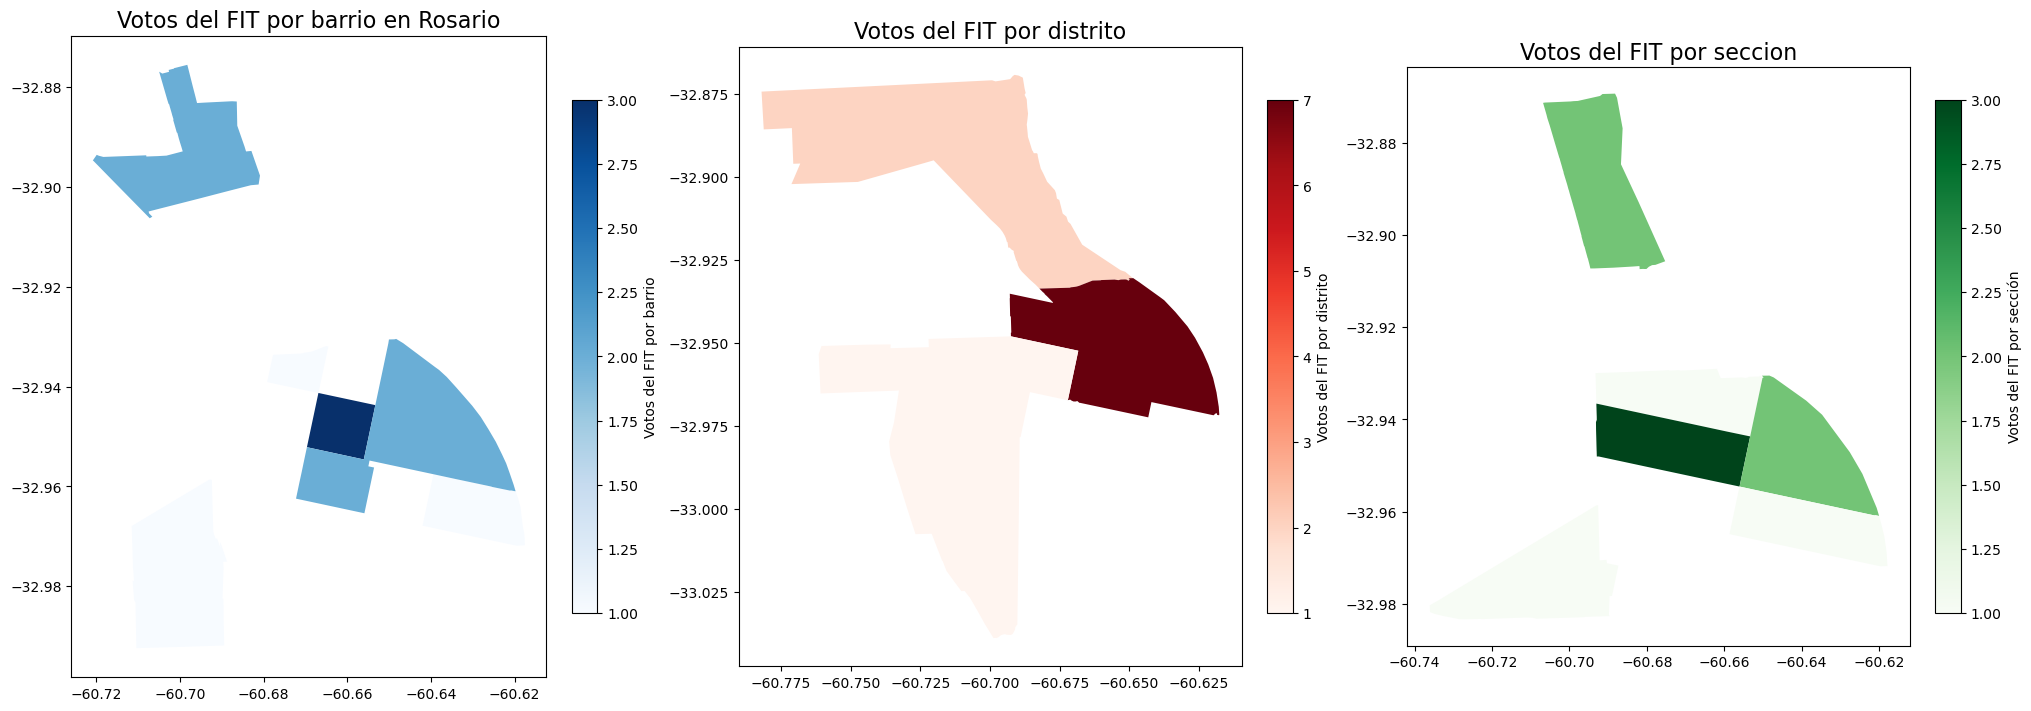

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_fit', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del FIT por barrio", 'shrink': 0.8})
axes[0].set_title('Votos del FIT por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_fit', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos del FIT por distrito', 'shrink': 0.8})
axes[1].set_title('Votos del FIT por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_fit', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos del FIT por sección', 'shrink': 0.8})
axes[2].set_title('Votos del FIT por seccion', fontsize=16)
plt.show()

In [80]:
gdf_votos_pnk=union[union['INT DE VOTO X ESPACIO']=='PNK']
conteo_votos_pnk = gdf_votos_pnk.groupby('BARRIO').size().reset_index(name='cantidad_votos_pnk')
barrios = barrios.merge(conteo_votos_pnk, on='BARRIO', how='left')
gdf_votos_pnk_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='PNK']
conteo_votos_pnk_dis = gdf_votos_pnk_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_pnk')
distritos = distritos.merge(conteo_votos_pnk_dis, on='DISTRITO', how='left')
gdf_votos_pnk_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='PNK']
conteo_votos_pnk_sec = gdf_votos_pnk_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_pnk')
secciones = secciones.merge(conteo_votos_pnk_sec, on='SECCION', how='left')

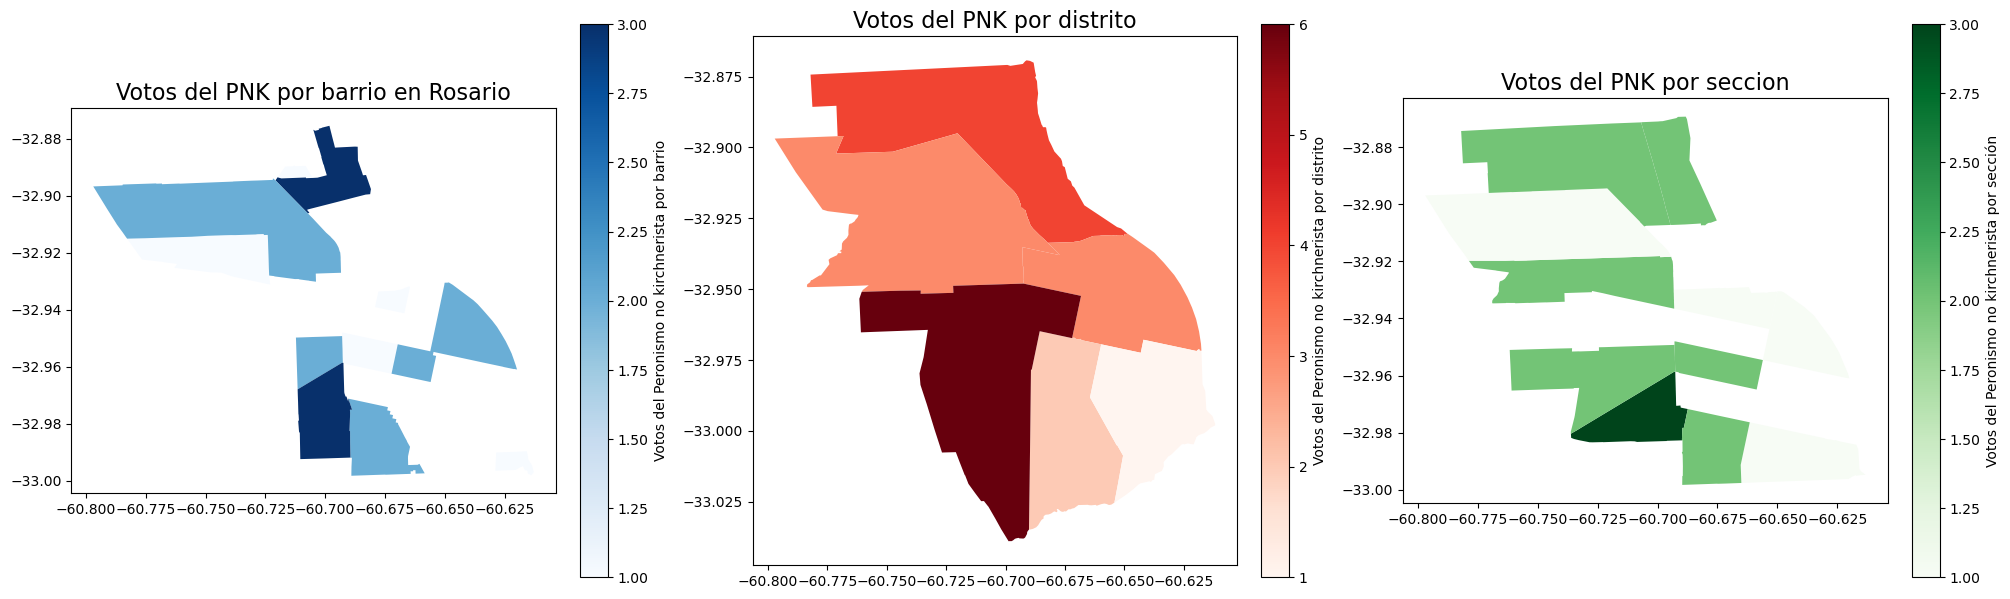

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_pnk', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del Peronismo no kirchnerista por barrio", 'shrink': 0.8})
axes[0].set_title('Votos del PNK por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_pnk', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Votos del Peronismo no kirchnerista por distrito', 'shrink': 0.8})
axes[1].set_title('Votos del PNK por distrito', fontsize=16)
secciones.plot(column='cantidad_votos_pnk', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Votos del Peronismo no kirchnerista por sección', 'shrink': 0.8})
axes[2].set_title('Votos del PNK por seccion', fontsize=16)
plt.show()

In [82]:
gdf_votos_ns=union[union['INT DE VOTO X ESPACIO']=='NINGUNO/NOSABE']
conteo_votos_ns = gdf_votos_ns.groupby('BARRIO').size().reset_index(name='cantidad_votos_ns')
barrios = barrios.merge(conteo_votos_ns, on='BARRIO', how='left')
gdf_votos_ns_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='NINGUNO/NOSABE']
conteo_votos_ns_dis = gdf_votos_ns_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_ns')
distritos = distritos.merge(conteo_votos_ns_dis, on='DISTRITO', how='left')
gdf_votos_ns_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='NINGUNO/NOSABE']
conteo_votos_ns_sec = gdf_votos_ns_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_ns')
secciones = secciones.merge(conteo_votos_ns_sec, on='SECCION', how='left')

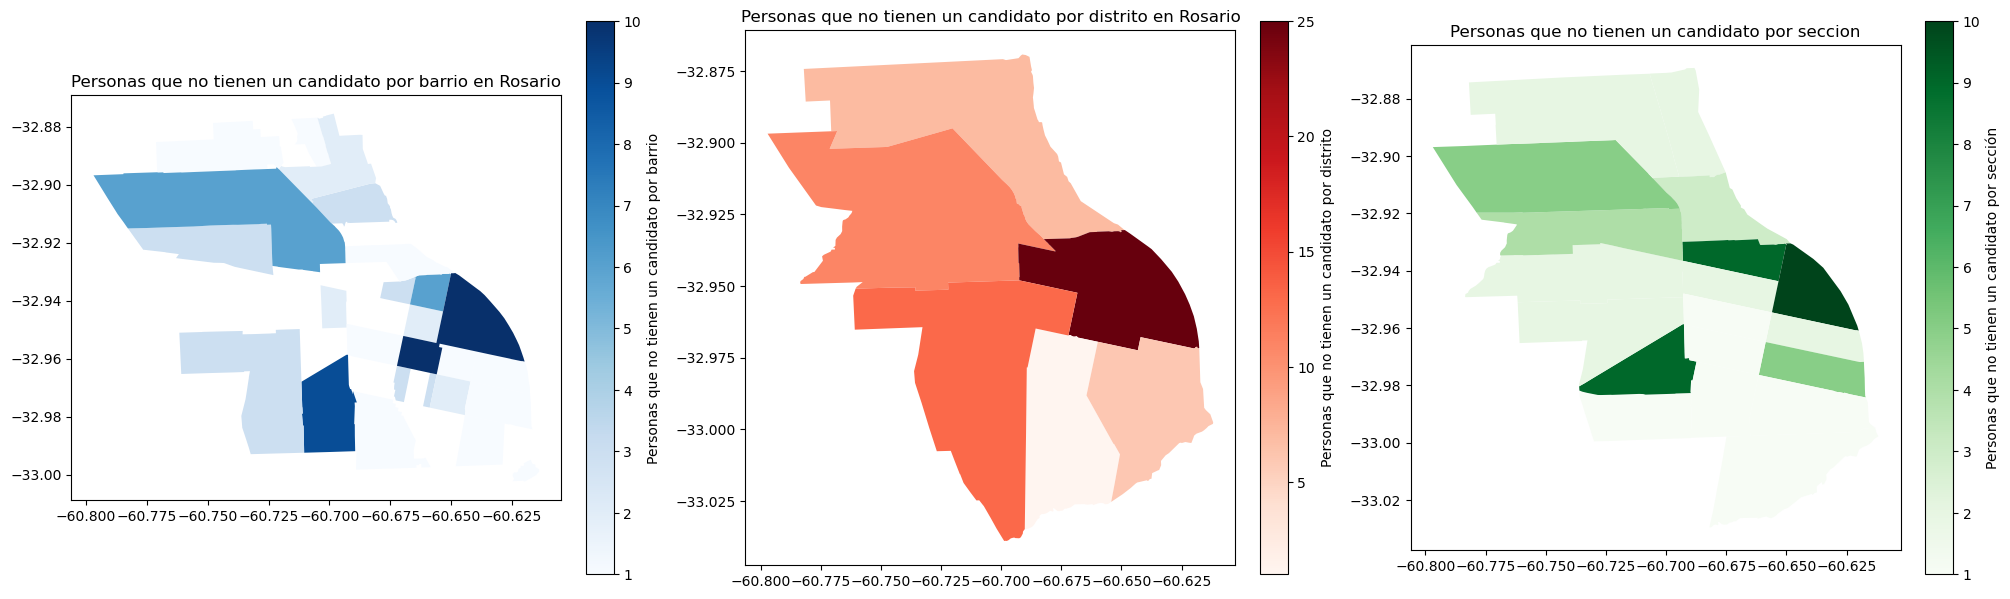

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_ns', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Personas que no tienen un candidato por barrio", 'shrink': 0.8})
axes[0].set_title('Personas que no tienen un candidato por barrio en Rosario', fontsize=12)
distritos.plot(column='cantidad_votos_ns', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Personas que no tienen un candidato por distrito', 'shrink': 0.8})
axes[1].set_title('Personas que no tienen un candidato por distrito en Rosario', fontsize=12)
secciones.plot(column='cantidad_votos_ns', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Personas que no tienen un candidato por sección', 'shrink': 0.8})
axes[2].set_title('Personas que no tienen un candidato por seccion', fontsize=12)
plt.show()

In [84]:
gdf_votos_otros=union[union['INT DE VOTO X ESPACIO']=='OTROS']
conteo_votos_otros = gdf_votos_otros.groupby('BARRIO').size().reset_index(name='cantidad_votos_otros')
barrios = barrios.merge(conteo_votos_otros, on='BARRIO', how='left')
gdf_votos_otros_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='OTROS']
conteo_votos_otros_dis = gdf_votos_otros_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_otros')
distritos = distritos.merge(conteo_votos_otros_dis, on='DISTRITO', how='left')
gdf_votos_otros_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='OTROS']
conteo_votos_otros_sec = gdf_votos_otros_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_otros')
secciones = secciones.merge(conteo_votos_otros_sec, on='SECCION', how='left')

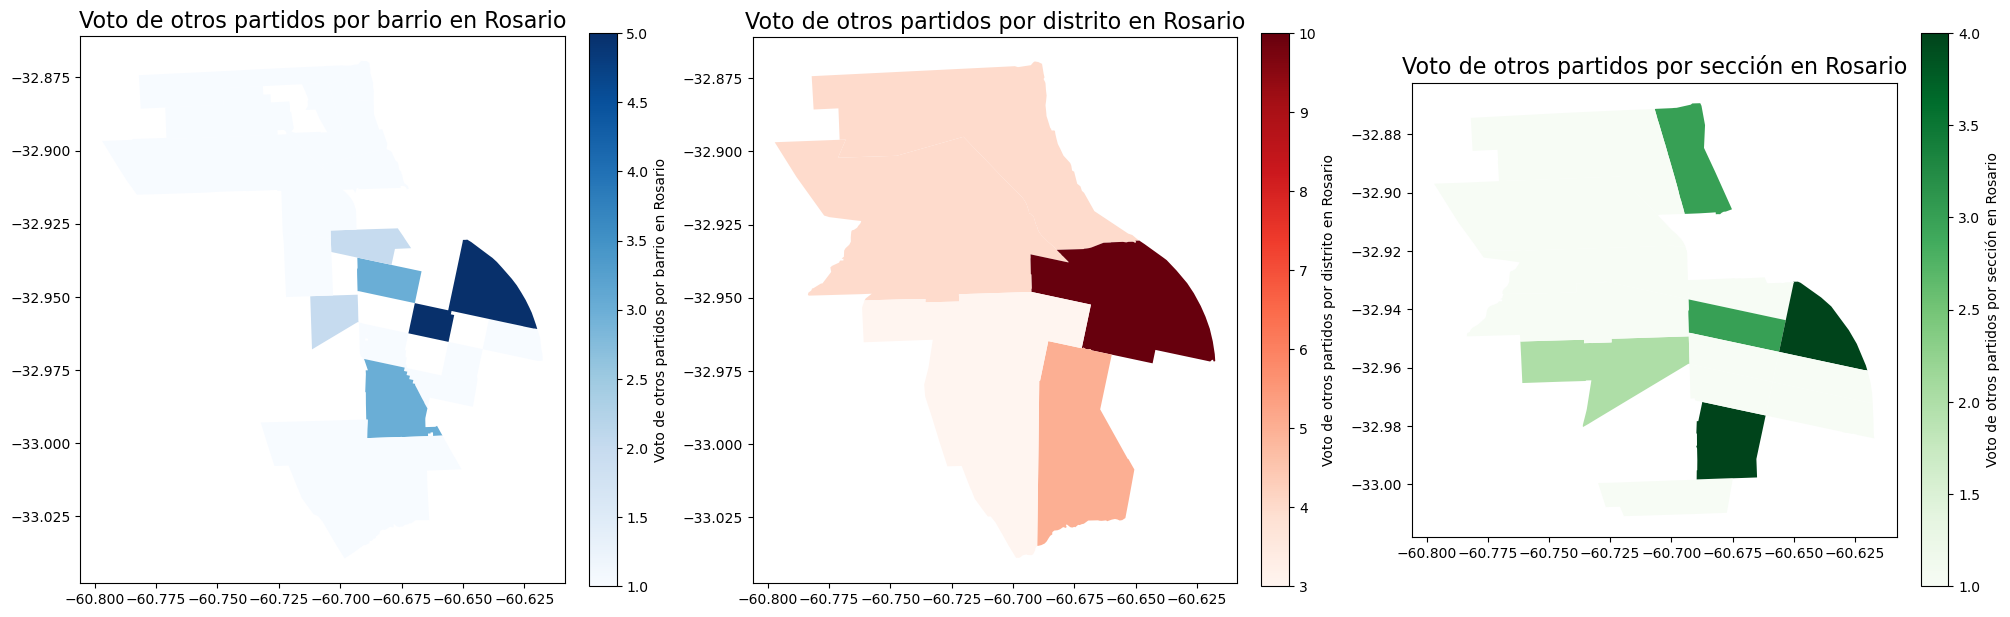

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
barrios.plot(column='cantidad_votos_otros', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Voto de otros partidos por barrio en Rosario", 'shrink': 0.8})
axes[0].set_title('Voto de otros partidos por barrio en Rosario', fontsize=16)
distritos.plot(column='cantidad_votos_otros', ax=axes[1], legend=True,cmap='Reds', legend_kwds={'label':'Voto de otros partidos por distrito en Rosario', 'shrink': 0.8})
axes[1].set_title('Voto de otros partidos por distrito en Rosario', fontsize=16)
secciones.plot(column='cantidad_votos_otros', ax=axes[2], legend=True, cmap='Greens', legend_kwds={'label':'Voto de otros partidos por sección en Rosario', 'shrink': 0.8})
axes[2].set_title('Voto de otros partidos por sección en Rosario', fontsize=16)
plt.show()

In [86]:
estratos['Geometría en GeoJSON'] = estratos['Geometría en GeoJSON'].apply(lambda x: shape(json.loads(x)))
estratos=estratos.set_geometry('Geometría en GeoJSON')
estratos=gpd.GeoDataFrame(estratos, geometry='Geometría en GeoJSON', crs='EPSG:4326')
estratos = estratos.dropna(subset=['Latitud del centroide', 'Longitud del centroide'])
estratos = estratos.dropna(subset=["Segmento socioeconómico del radio"])
estratos = estratos.dropna(subset=['Geometría en GeoJSON'])
estratos['Segmento socioeconómico del radio']
estratos['Segmento socioeconómico del radio'] = estratos['Segmento socioeconómico del radio'].astype(int)

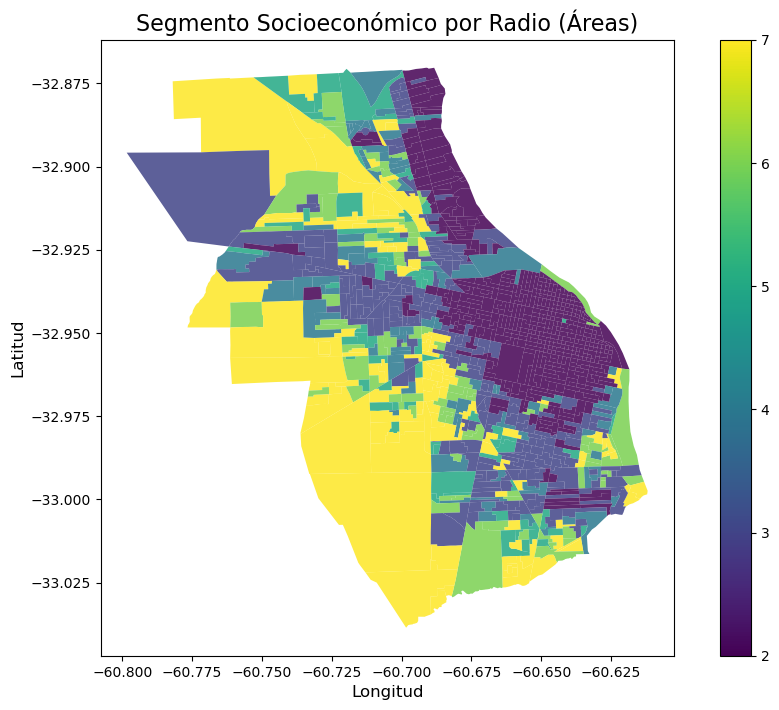

In [87]:
fig, ax = plt.subplots(figsize=(12, 8))
estratos.plot(column='Segmento socioeconómico del radio', ax=ax, legend=True, cmap='viridis', alpha=0.85)  # alpha controla la opacidad del área
ax.set_title('Segmento Socioeconómico por Radio (Áreas)', fontsize=16)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)
plt.show()

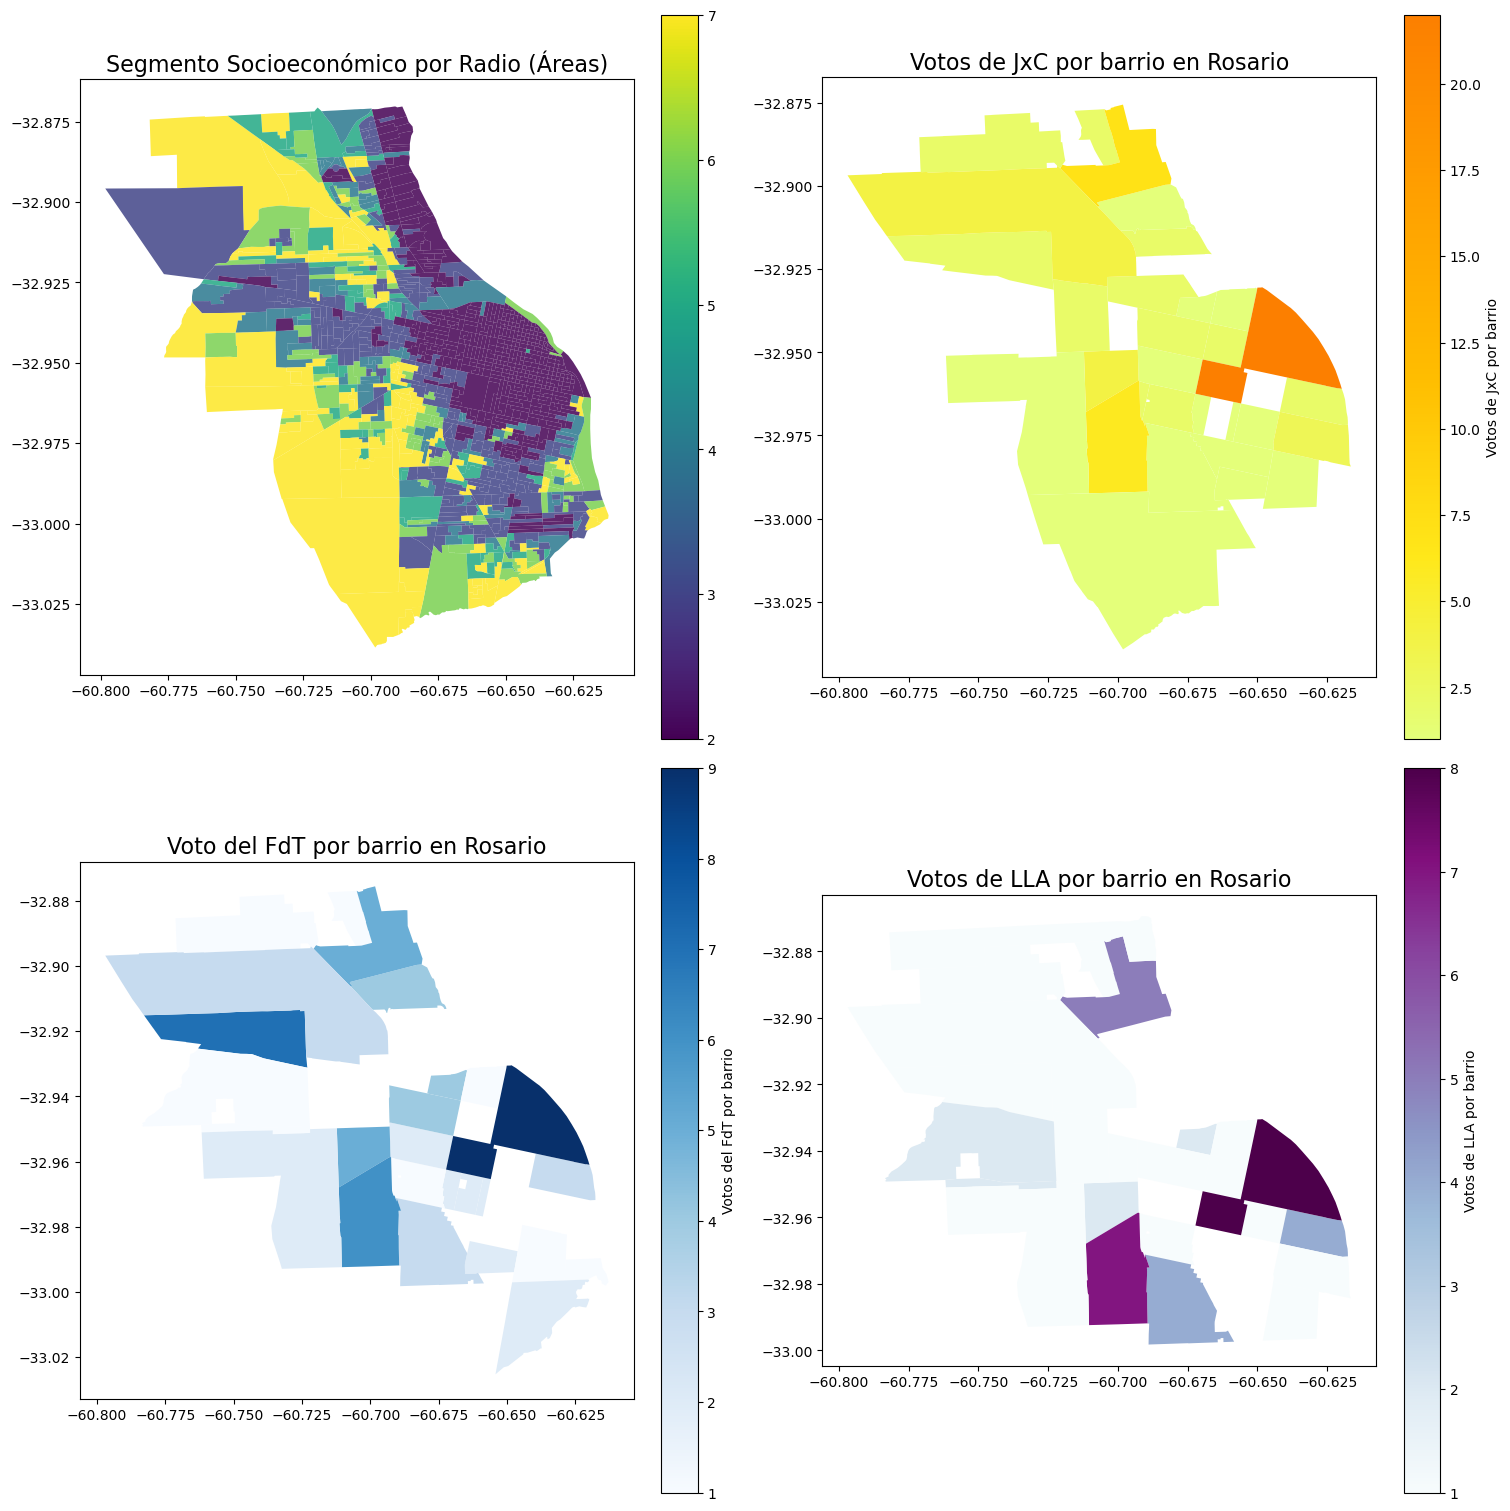

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)
barrios.plot(column='cantidad_votos_fdt', ax=axes[1,0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del FdT por barrio"})
axes[1,0].set_title('Voto del FdT por barrio en Rosario', fontsize=16)
estratos.plot(column='Segmento socioeconómico del radio', ax=axes[0,0], legend=True, cmap='viridis', alpha=0.85)  # alpha controla la opacidad del área
axes[0,0].set_title('Segmento Socioeconómico por Radio (Áreas)', fontsize=16)
barrios.plot(column='cantidad_votos_jxc', ax=axes[0,1], legend=True, cmap='Wistia', legend_kwds={'label': "Votos de JxC por barrio"})
axes[0,1].set_title('Votos de JxC por barrio en Rosario', fontsize=16)
barrios.plot(column='cantidad_votos_lib', ax=axes[1,1], legend=True, cmap='BuPu', legend_kwds={'label': "Votos de LLA por barrio"})
axes[1,1].set_title('Votos de LLA por barrio en Rosario', fontsize=16)
plt.show()

In [89]:
niveleducativo['Geometría en GeoJSON'] = niveleducativo['Geometría en GeoJSON'].apply(lambda x: shape(json.loads(x)))
niveleducativo=niveleducativo.set_geometry('Geometría en GeoJSON')
niveleducativo=gpd.GeoDataFrame(niveleducativo, geometry='Geometría en GeoJSON', crs='EPSG:4326')
niveleducativo = niveleducativo.dropna(subset=['Latitud del centroide', 'Longitud del centroide'])
niveleducativo = niveleducativo.dropna(subset=['Población de 18 y más con primaria incompleta o menos'])
niveleducativo = niveleducativo.dropna(subset=['Población de 18 y más con universitario completo o más'])
niveleducativo = niveleducativo.dropna(subset=['Geometría en GeoJSON'])
niveleducativo['Población de 18 y más con primaria incompleta o menos']
niveleducativo['Población de 18 y más con primaria incompleta o menos'] = niveleducativo['Población de 18 y más con primaria incompleta o menos'].astype(int)
niveleducativo['Población de 18 y más con universitario completo o más']
niveleducativo['Población de 18 y más con universitario completo o más'] = niveleducativo['Población de 18 y más con universitario completo o más'].astype(int)

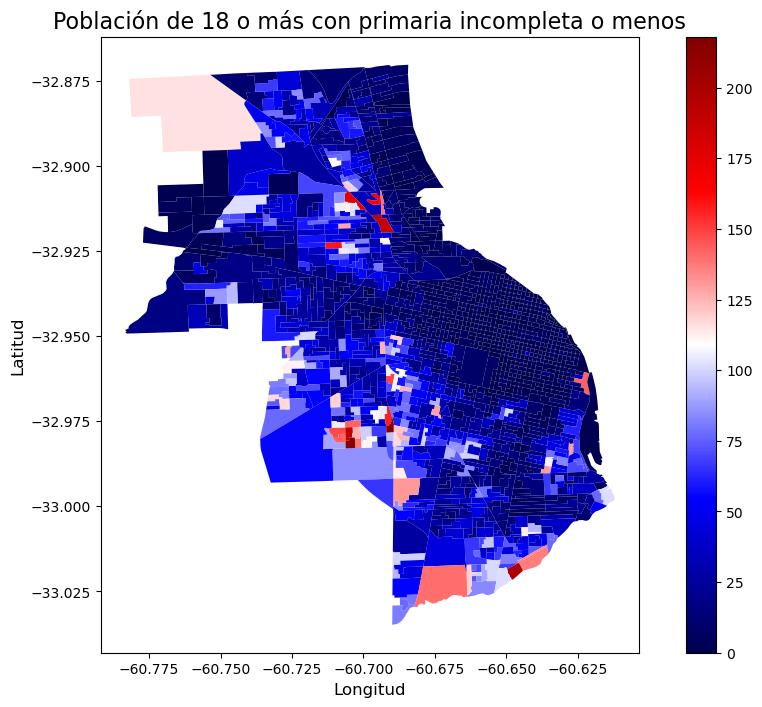

In [90]:
fig, ax = plt.subplots(figsize=(12, 8))
niveleducativo.plot(column='Población de 18 y más con primaria incompleta o menos', ax=ax, legend=True, cmap='seismic', alpha=1)  # alpha controla la opacidad del área
ax.set_title('Población de 18 o más con primaria incompleta o menos', fontsize=16)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)
plt.show()

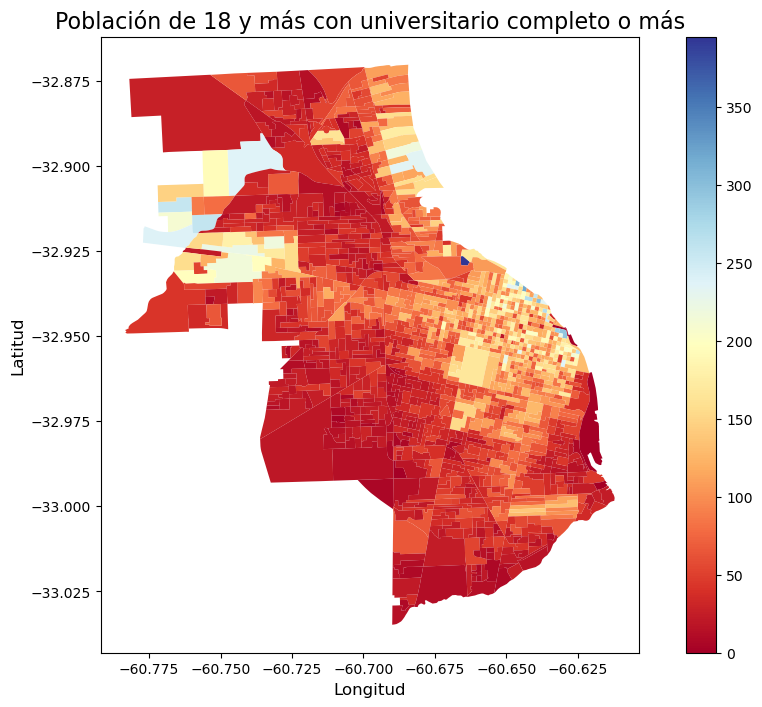

In [91]:
fig, ax = plt.subplots(figsize=(12, 8))
niveleducativo.plot(column='Población de 18 y más con universitario completo o más', ax=ax, legend=True, cmap='RdYlBu', alpha=1)
ax.set_title('Población de 18 y más con universitario completo o más', fontsize=16)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)
plt.show()

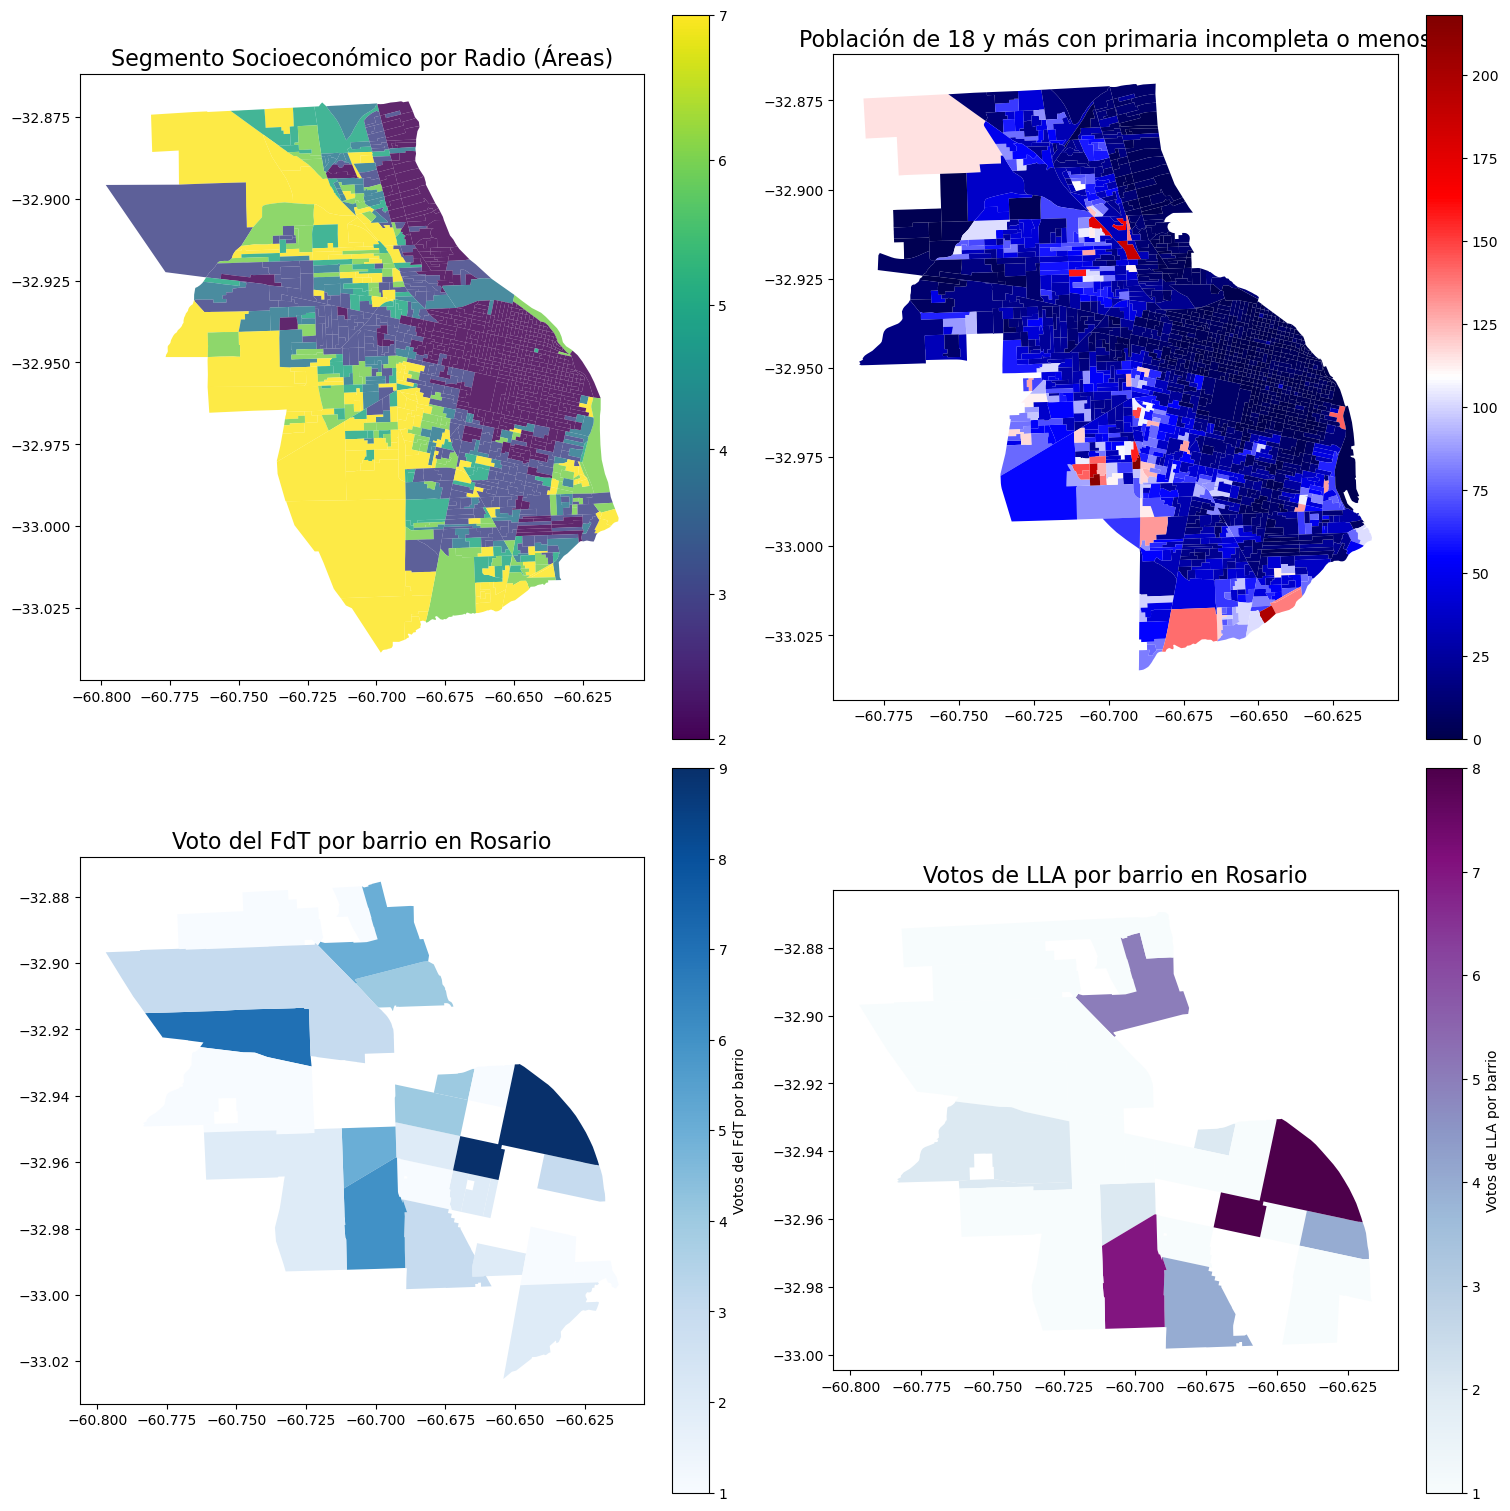

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)
barrios.plot(column='cantidad_votos_fdt', ax=axes[1,0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del FdT por barrio"})
axes[1,0].set_title('Voto del FdT por barrio en Rosario', fontsize=16)
estratos.plot(column='Segmento socioeconómico del radio', ax=axes[0,0], legend=True, cmap='viridis', alpha=0.85)
axes[0,0].set_title('Segmento Socioeconómico por Radio (Áreas)', fontsize=16)
niveleducativo.plot(column='Población de 18 y más con primaria incompleta o menos', ax=axes[0,1], legend=True, cmap='seismic', alpha=1)  # alpha controla la opacidad del área
axes[0,1].set_title('Población de 18 y más con primaria incompleta o menos', fontsize=16)
barrios.plot(column='cantidad_votos_lib', ax=axes[1,1], legend=True, cmap='BuPu', legend_kwds={'label': "Votos de LLA por barrio"})
axes[1,1].set_title('Votos de LLA por barrio en Rosario', fontsize=16)
plt.show()

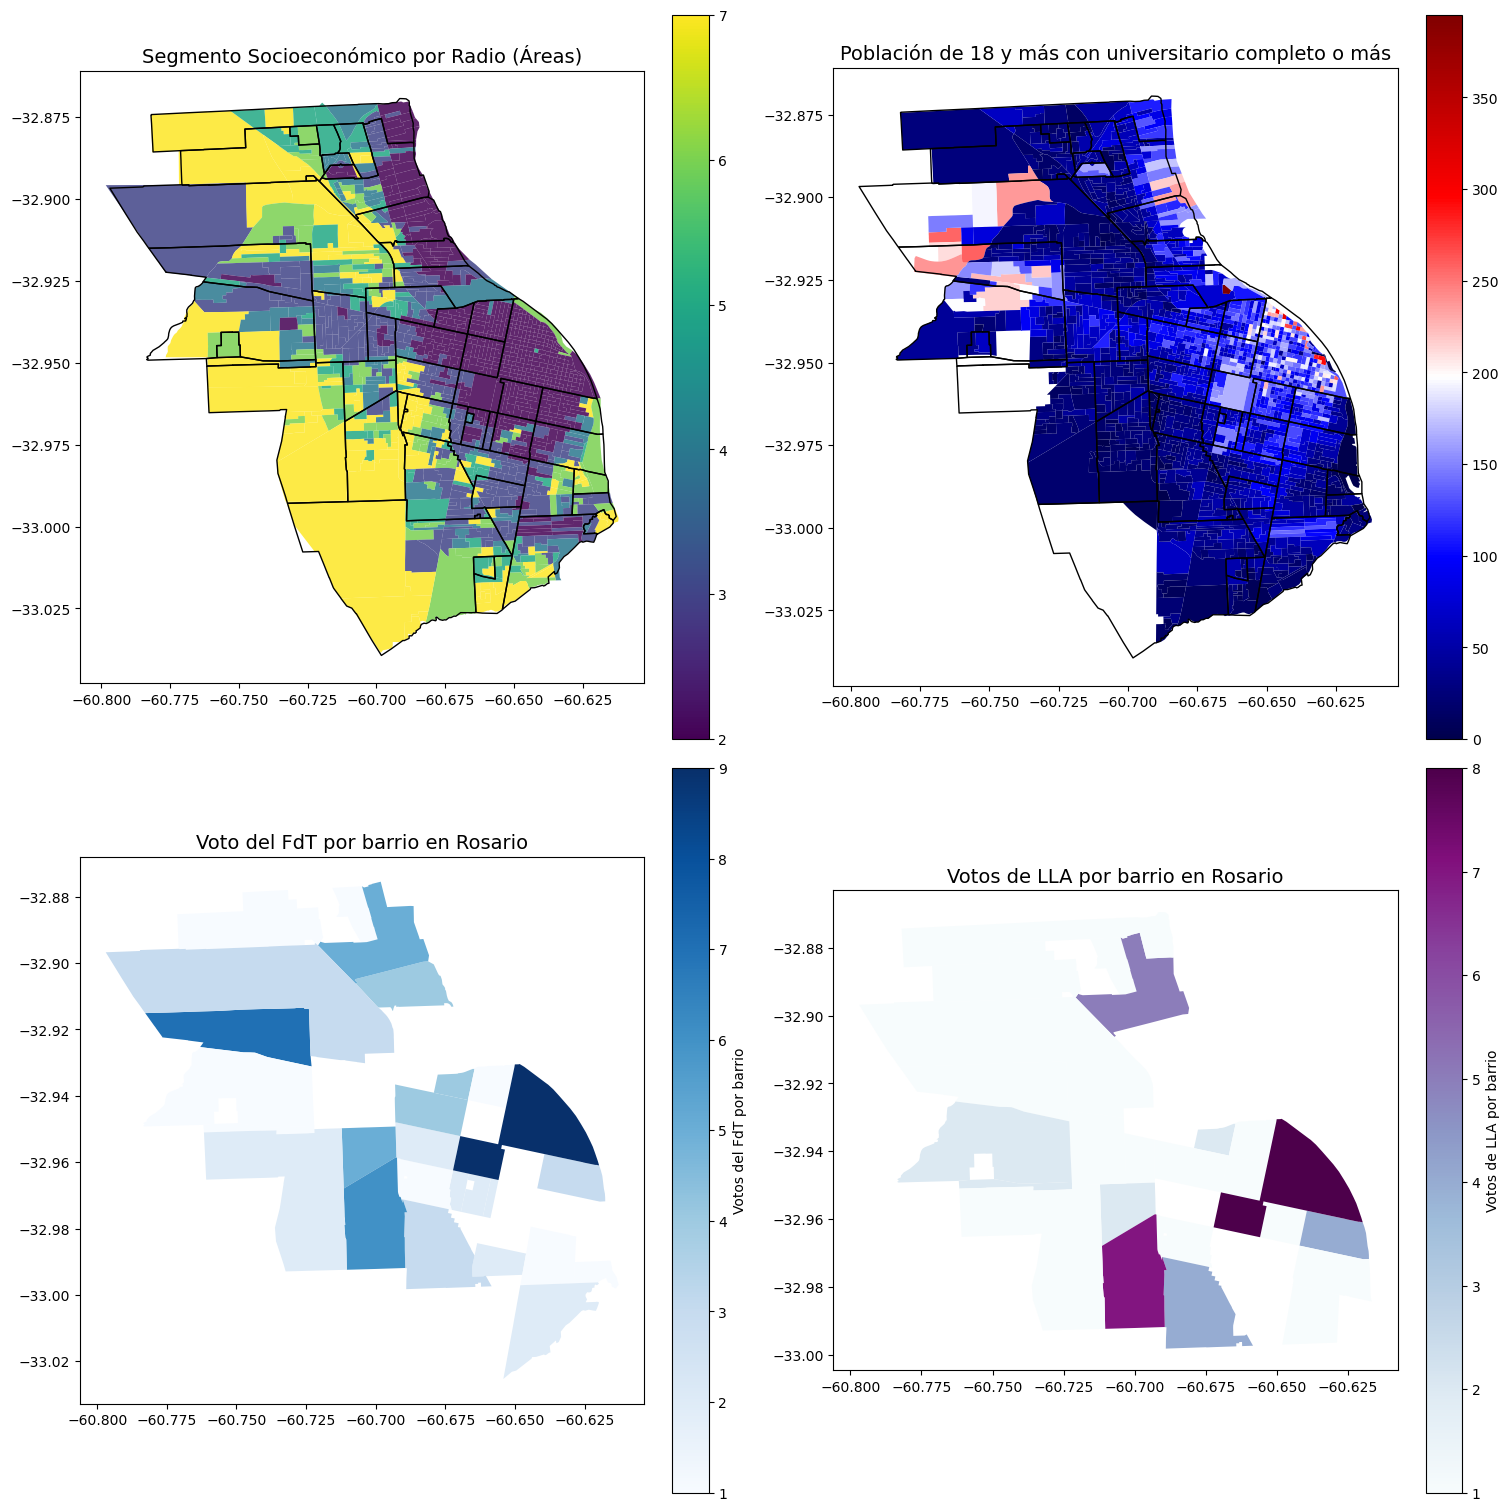

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)
barrios.plot(column='cantidad_votos_fdt', ax=axes[1,0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del FdT por barrio"})
axes[1,0].set_title('Voto del FdT por barrio en Rosario', fontsize=14)
estratos.plot(column='Segmento socioeconómico del radio', ax=axes[0,0], legend=True, cmap='viridis', alpha=0.85)
barrios.boundary.plot(ax=axes[0,0],edgecolor='black',linewidth=1)
axes[0,0].set_title('Segmento Socioeconómico por Radio (Áreas)', fontsize=14)
niveleducativo.plot(column='Población de 18 y más con universitario completo o más', ax=axes[0,1], legend=True, cmap='seismic', alpha=1)  # alpha controla la opacidad del área
axes[0,1].set_title('Población de 18 y más con universitario completo o más', fontsize=14)
barrios.boundary.plot(ax=axes[0,1],edgecolor='black',linewidth=1)
barrios.plot(column='cantidad_votos_lib', ax=axes[1,1], legend=True, cmap='BuPu', legend_kwds={'label': "Votos de LLA por barrio"})
axes[1,1].set_title('Votos de LLA por barrio en Rosario', fontsize=14)
plt.show()

Text(0.5, 1.0, 'Población de 18 y más con universitario completo o más')

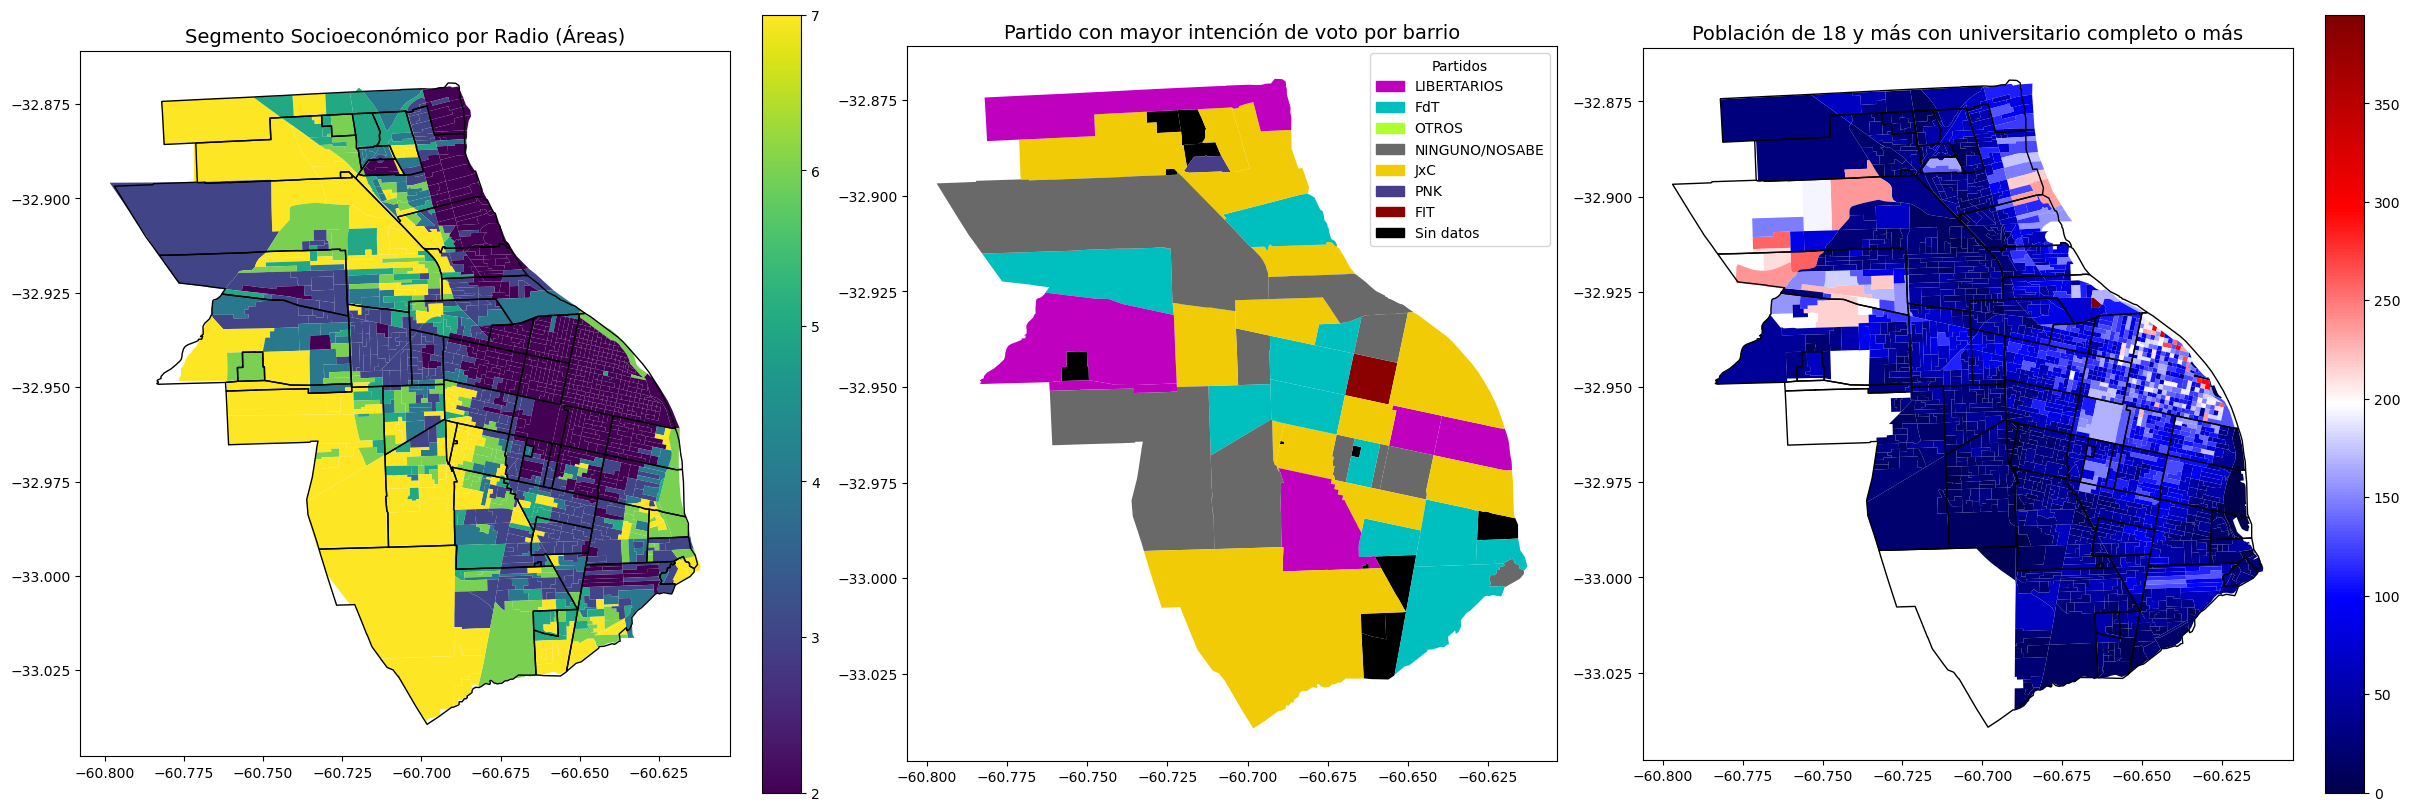

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), constrained_layout=True)
estratos.plot(column='Segmento socioeconómico del radio', ax=axes[0], legend=True, cmap='viridis', alpha=1)
barrios.boundary.plot(ax=axes[0],edgecolor='black',linewidth=1)
axes[0].set_title('Segmento Socioeconómico por Radio (Áreas)', fontsize=14)
barrios.plot(color=barrios['color'], ax=axes[1])
axes[1].set_title('Partido con mayor intención de voto por barrio', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[1].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
niveleducativo.plot(column='Población de 18 y más con universitario completo o más', ax=axes[2], legend=True, cmap='seismic', alpha=1)
barrios.boundary.plot(ax=axes[2],edgecolor='black',linewidth=1)
axes[2].set_title('Población de 18 y más con universitario completo o más', fontsize=14)

In [95]:
pobreza['Geometría en GeoJSON'] = pobreza['Geometría en GeoJSON'].apply(lambda x: shape(json.loads(x)))
pobreza=pobreza.set_geometry('Geometría en GeoJSON')
pobreza=gpd.GeoDataFrame(pobreza, geometry='Geometría en GeoJSON', crs='EPSG:4326')
pobreza = pobreza.dropna(subset=['Latitud del centroide', 'Longitud del centroide'])
pobreza = pobreza.dropna(subset=['Nivel de incidencia de pobreza crónica'])
pobreza = pobreza.dropna(subset=['Geometría en GeoJSON'])
pobreza['Nivel de incidencia de pobreza crónica'] = pobreza['Nivel de incidencia de pobreza crónica'].astype(int)

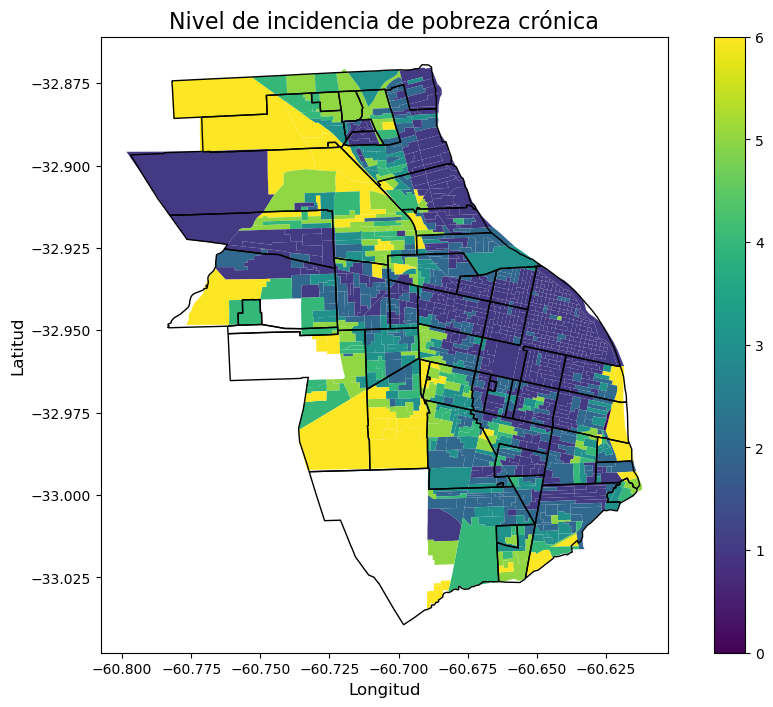

In [96]:
fig, ax = plt.subplots(figsize=(12, 8))
pobreza.plot(column='Nivel de incidencia de pobreza crónica', ax=ax, legend=True, cmap='viridis', alpha=1)
ax.set_title('Nivel de incidencia de pobreza crónica', fontsize=16)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)
barrios.boundary.plot(ax=ax,edgecolor='black',linewidth=1)
plt.show()

Text(0.5, 1.0, 'Votos de LLA por barrio en Rosario')

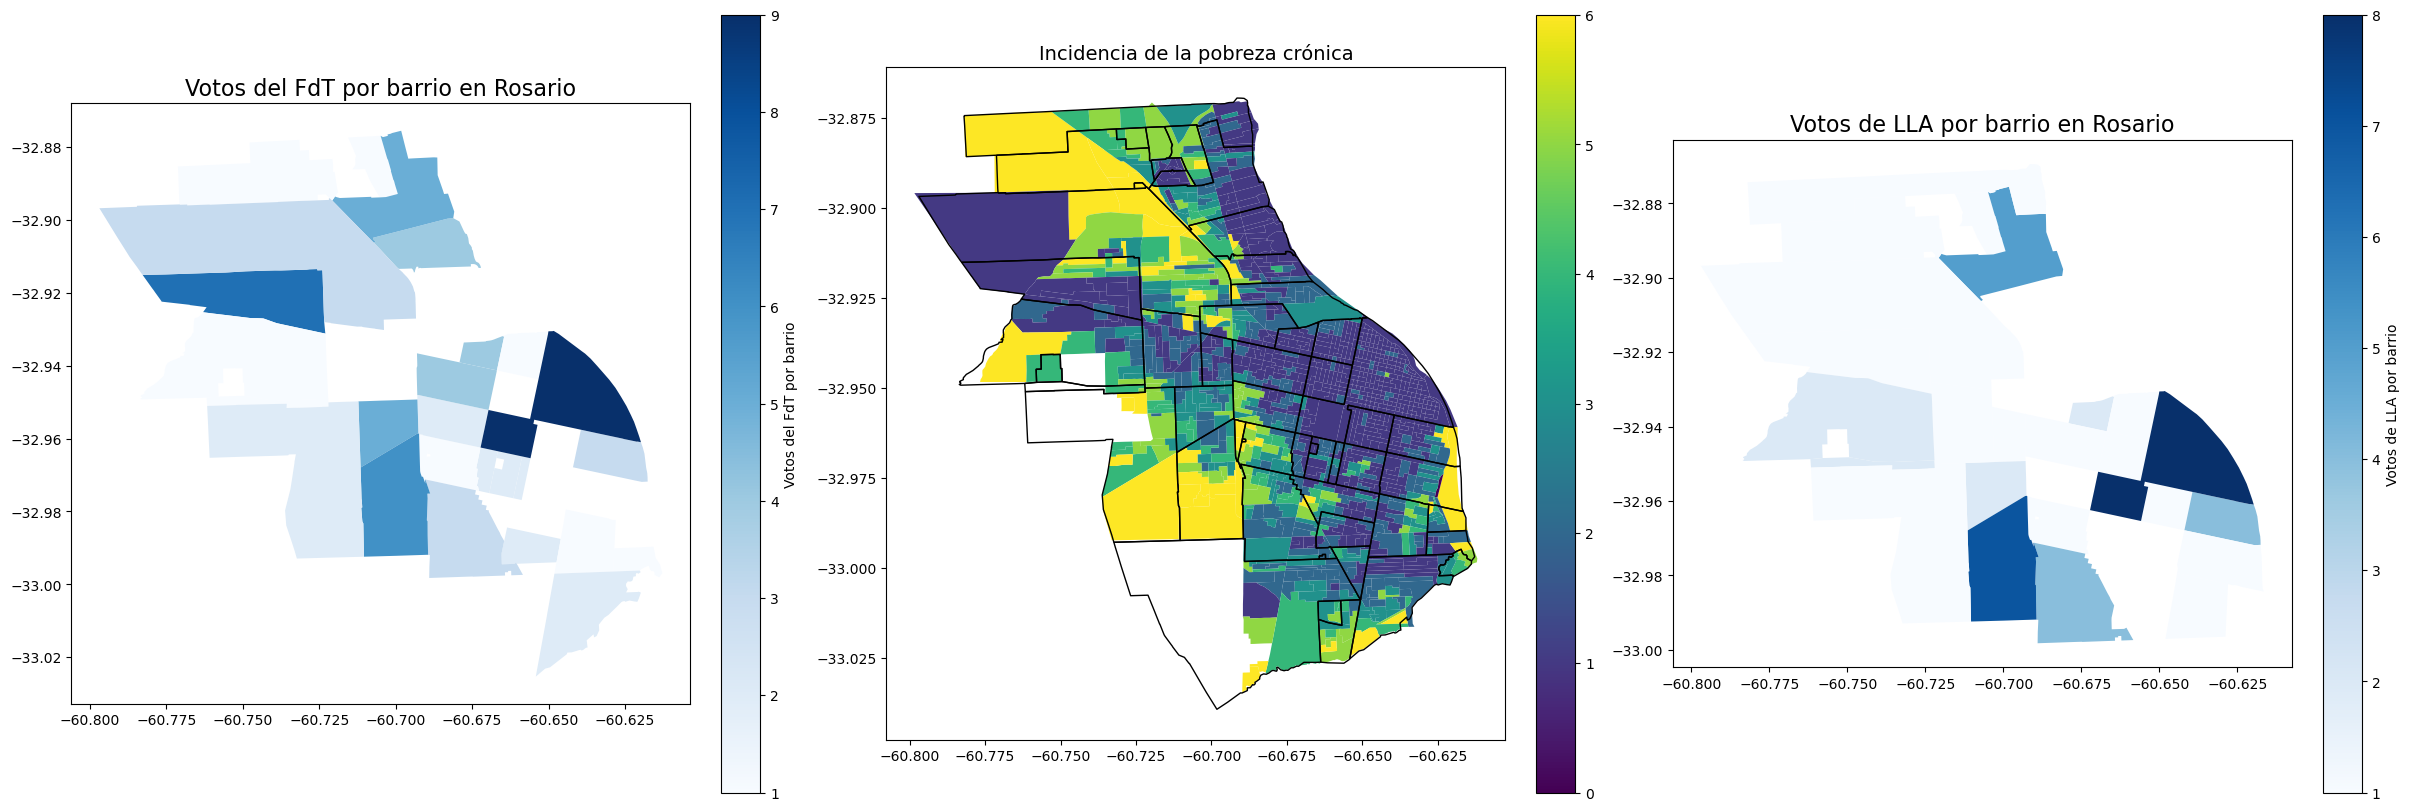

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), constrained_layout=True)
barrios.plot(column='cantidad_votos_fdt', ax=axes[0], legend=True, cmap='Blues', legend_kwds={'label': "Votos del FdT por barrio"})
axes[0].set_title('Votos del FdT por barrio en Rosario', fontsize=16)
pobreza.plot(column='Nivel de incidencia de pobreza crónica', ax=axes[1], legend=True, cmap='viridis', alpha=1)
axes[1].set_title('Incidencia de la pobreza crónica', fontsize=14)
barrios.boundary.plot(ax=axes[1],edgecolor='black',linewidth=1)
barrios.plot(column='cantidad_votos_lib', ax=axes[2], legend=True, cmap='Blues', legend_kwds={'label': "Votos de LLA por barrio"})
axes[2].set_title('Votos de LLA por barrio en Rosario', fontsize=16)

In [98]:
df['VOTO_LIBERTARIOS'] = df['INT DE VOTO X ESPACIO'].apply(lambda x: 1 if x == 'LIBERTARIOS' else 0)
df['GENERO'] = df['GENERO'] == 'Masculino' 


In [99]:
df['VOTO_LIBERTARIOS'] = pd.to_numeric(df['VOTO_LIBERTARIOS'], errors='coerce')
df['GENERO'] = df['GENERO'].astype(int)
df = df.dropna(subset=['VOTO_LIBERTARIOS', 'GENERO'])

X = df[['GENERO']]  
y = df['VOTO_LIBERTARIOS']

# Añadir una constante (intercepto) a las variables independientes
X = sm.add_constant(X)

# Ajustar el modelo de regresión logística
model = sm.Logit(y, X)

# Ajustar el modelo
result = model.fit()

# Mostrar los resultados del modelo
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.398599
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       VOTO_LIBERTARIOS   No. Observations:                  313
Model:                          Logit   Df Residuals:                      311
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                 0.06975
Time:                        17:41:08   Log-Likelihood:                -124.76
converged:                       True   LL-Null:                       -134.12
Covariance Type:            nonrobust   LLR p-value:                 1.523e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7154      0.344     -7.889      0.000      -3.390      -2.041
GENERO         1.5192      0.

Analisis de regresion entre la variable GENERO y la posibilidad de votar a los libertarios
El coeficiente para la variable GENERO da 1.5192. Esto muestra que los hombres tienen un aumento en las probabilidades de votar por LLA. 
El valor P para GENERO es 0, lo que significa que el efecto de la variable sobre la probabilidad de votar por LLA es alta.
El valor P para la constante es 0, lo que significa que el intercepto es significativo.
Los intervalos de confianza para la constante y para la variable genero estan por encima de 0, lo que indica que el genero (masculino) tiene un impacto positivo y significativo en el voto a los libertarios.
El pseudo R cuadrado es 0.06975, lo que indica que el modelo explica aproximadamente el 6.98% de la variabilidad en la variable dependiente (VOTO_LIBERTARIOS).


In [100]:
df['VOTO_FIT'] = df['INT DE VOTO X ESPACIO'].apply(lambda x: 1 if x == 'FIT' else 0)
df_filtrado = df[df['EDAD'] == '26 a 35']
print(df.head())

   Unnamed: 0 interview__key METODO  Coord1__Latitude  Coord1__Longitude  \
0           0    56-56-25-81    F2F        -32.881458         -60.695274   
1           1    67-96-98-06    F2F        -32.882259         -60.693571   
2           2    24-21-01-39    F2F        -32.884731         -60.692882   
3           3    84-96-80-81    F2F        -32.884673         -60.693464   
4           4    21-29-79-64    F2F        -32.918833         -60.703628   

       EDAD  GENERO INT DE VOTO X ESPACIO      RADIO  \
0  56 y mas       1           LIBERTARIOS  820840409   
1   36 a 45       1                 OTROS  820840410   
2  56 y mas       0                 OTROS  820840502   
3   26 a 35       1           LIBERTARIOS  820840502   
4   36 a 45       0        NINGUNO/NOSABE  820841013   

                                       geometry    color  VOTO_LIBERTARIOS  \
0  POINT (-60.6952736992389 -32.88145751226693)  #BF00BF                 1   
1  POINT (-60.6935706641525 -32.88225878030062)  #

In [101]:
df['VOTO_FIT'] = pd.to_numeric(df['VOTO_FIT'], errors='coerce')
df['rango_26_35'] = df['EDAD'] == '26 a 35'
df['rango_26_35'] = df['rango_26_35'].astype(int)
print(df)

     Unnamed: 0 interview__key METODO  Coord1__Latitude  Coord1__Longitude  \
0             0    56-56-25-81    F2F        -32.881458         -60.695274   
1             1    67-96-98-06    F2F        -32.882259         -60.693571   
2             2    24-21-01-39    F2F        -32.884731         -60.692882   
3             3    84-96-80-81    F2F        -32.884673         -60.693464   
4             4    21-29-79-64    F2F        -32.918833         -60.703628   
..          ...            ...    ...               ...                ...   
308         367   347615540259    IVR        -32.941000         -60.688295   
309         368   347615540658    IVR        -32.970114         -60.653051   
310         369   347615672682    IVR        -32.907759         -60.752721   
311         370   348715470373    IVR        -32.942161         -60.639935   
312         371   387154502466    IVR        -32.957100         -60.637709   

         EDAD  GENERO INT DE VOTO X ESPACIO      RADIO  \
0    

In [102]:
X = df[['rango_26_35']]  # Variables independientes
y = df['VOTO_FIT']  # Variable dependiente (asegúrate de que esta columna sea binaria)

# Añadir una constante (intercepto) a las variables independientes
X = sm.add_constant(X)

# Ajustar el modelo de regresión logística
model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.139305
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               VOTO_FIT   No. Observations:                  313
Model:                          Logit   Df Residuals:                      311
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                 0.01518
Time:                        17:41:09   Log-Likelihood:                -43.602
converged:                       True   LL-Null:                       -44.275
Covariance Type:            nonrobust   LLR p-value:                    0.2463
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.6032      0.383     -9.406      0.000      -4.354      -2.852
rango_26_35     0.8731    

El valor del coeficiente para el rango de 26 a 35 años es de 0.8731, lo cual indica que hay un aumento en la probabilidad de votar por FIT en comparación con otras categorías de edad. 
El valor de P para rango_26_35 es 0.218, lo que es mayor que 0.05. Esto indica que el coeficiente no es estadísticamente significativo al nivel del 5%.
El Pseudo R cuadrado es muy bajo (0.01518), lo que indica que el modelo explica muy poco de la variabilidad del voto al FIT.


In [103]:
dummies = pd.get_dummies(df["INT DE VOTO X ESPACIO"], prefix="INT DE VOTO X ESPACIO")
df = pd.concat([df, dummies], axis=1)

In [104]:
dummies = pd.get_dummies(df["EDAD"], prefix="EDAD")
df = pd.concat([df, dummies], axis=1)

In [105]:
estratos=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/poblaciones/Estratificaci%C3%B3n%20de%20radios%20censales%20-%20Rosario.csv')
estratos['Geometría en GeoJSON'] = estratos['Geometría en GeoJSON'].apply(lambda x: shape(json.loads(x)))
estratos=estratos.set_geometry('Geometría en GeoJSON')
estratos=gpd.GeoDataFrame(estratos, geometry='Geometría en GeoJSON', crs='EPSG:4326')
estratos = estratos.dropna(subset=['Latitud del centroide', 'Longitud del centroide'])
estratos = estratos.dropna(subset=["Segmento socioeconómico del radio"])
estratos = estratos.dropna(subset=['Geometría en GeoJSON'])

In [106]:
geometry = [Point(xy) for xy in zip(df['Coord1__Longitude'], df['Coord1__Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs('EPSG:4326', inplace=True)
union=gpd.sjoin(gdf, estratos, how='inner', predicate='within')
union['Hogares con hacinamiento (>= 3 personas por cuarto)']

0       0
1       0
2      15
3      15
4      21
       ..
308     1
309     0
310     6
311     0
312     0
Name: Hogares con hacinamiento (>= 3 personas por cuarto), Length: 313, dtype: object

In [107]:
union['Segmento socioeconómico del radio']=union['Segmento socioeconómico del radio'].astype(int)
union['Hogares con jefatura femenina']= union['Hogares con jefatura femenina'].astype(int)

In [108]:
X = union[['GENERO','Hogares con jefatura femenina']]
y = union['INT DE VOTO X ESPACIO_LIBERTARIOS']   
X = sm.add_constant(X)

In [109]:
model = sm.Logit(y, X)
results = model.fit()  

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.398270
         Iterations 7
                                   Logit Regression Results                                  
Dep. Variable:     INT DE VOTO X ESPACIO_LIBERTARIOS   No. Observations:                  313
Model:                                         Logit   Df Residuals:                      310
Method:                                          MLE   Df Model:                            2
Date:                               Tue, 26 Nov 2024   Pseudo R-squ.:                 0.07051
Time:                                       17:41:12   Log-Likelihood:                -124.66
converged:                                      True   LL-Null:                       -134.12
Covariance Type:                           nonrobust   LLR p-value:                 7.814e-05
                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [110]:
union['Hogares con al menos un indicador NBI']=union['Hogares con al menos un indicador NBI'].astype(int)
union['Hogares con hacinamiento (>= 3 personas por cuarto)']=union['Hogares con hacinamiento (>= 3 personas por cuarto)'].astype(int)
union['Hogares con indicadores de alta marginalidad']=union['Hogares con indicadores de alta marginalidad'].astype(int)
union['Población de 18 a 29 que no estudia ni trabaja']=union['Población de 18 a 29 que no estudia ni trabaja'].astype(int)
union['Jefes sin secundaria completa']=union['Jefes sin secundaria completa'].astype(int)
union['Hogares con computadora']=union['Hogares con computadora'].astype(int)

In [111]:
X = union[['Hogares con al menos un indicador NBI','Hogares con hacinamiento (>= 3 personas por cuarto)','Hogares con indicadores de alta marginalidad','Segmento socioeconómico del radio','Población de 18 a 29 que no estudia ni trabaja']]
y = union['INT DE VOTO X ESPACIO_FdT']   
X = sm.add_constant(X)
model = sm.Logit(y, X)
results = model.fit()  

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.527601
         Iterations 6
                               Logit Regression Results                              
Dep. Variable:     INT DE VOTO X ESPACIO_FdT   No. Observations:                  313
Model:                                 Logit   Df Residuals:                      307
Method:                                  MLE   Df Model:                            5
Date:                       Tue, 26 Nov 2024   Pseudo R-squ.:                 0.01462
Time:                               17:41:13   Log-Likelihood:                -165.14
converged:                              True   LL-Null:                       -167.59
Covariance Type:                   nonrobust   LLR p-value:                    0.4284
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [112]:
X = union[['Hogares con al menos un indicador NBI','Hogares con hacinamiento (>= 3 personas por cuarto)','Hogares con indicadores de alta marginalidad','Segmento socioeconómico del radio','Población de 18 a 29 que no estudia ni trabaja']]
y = union['INT DE VOTO X ESPACIO_FIT']   
X = sm.add_constant(X)
model = sm.Logit(y, X)
results = model.fit()  

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.128886
         Iterations 12
                               Logit Regression Results                              
Dep. Variable:     INT DE VOTO X ESPACIO_FIT   No. Observations:                  313
Model:                                 Logit   Df Residuals:                      307
Method:                                  MLE   Df Model:                            5
Date:                       Tue, 26 Nov 2024   Pseudo R-squ.:                 0.08884
Time:                               17:41:13   Log-Likelihood:                -40.341
converged:                              True   LL-Null:                       -44.275
Covariance Type:                   nonrobust   LLR p-value:                    0.1637
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [113]:
X = union[['Segmento socioeconómico del radio','Población de 18 a 29 que no estudia ni trabaja','Jefes sin secundaria completa','Hogares con computadora']]
y = union['INT DE VOTO X ESPACIO_LIBERTARIOS']   
X = sm.add_constant(X)
model = sm.Logit(y, X)
results = model.fit()  

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.425439
         Iterations 6
                                   Logit Regression Results                                  
Dep. Variable:     INT DE VOTO X ESPACIO_LIBERTARIOS   No. Observations:                  313
Model:                                         Logit   Df Residuals:                      308
Method:                                          MLE   Df Model:                            4
Date:                               Tue, 26 Nov 2024   Pseudo R-squ.:                0.007107
Time:                                       17:41:13   Log-Likelihood:                -133.16
converged:                                      True   LL-Null:                       -134.12
Covariance Type:                           nonrobust   LLR p-value:                    0.7530
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [114]:
union['Población de 18 y más hasta primaria']=union['Población de 18 y más hasta primaria'].astype(int)
union['Población de 18 y más con primaria y secundario completo']=union['Población de 18 y más con primaria y secundario completo'].astype(int)
union['Población de 18 y más con secundario completo o terciario sin universitario completo']=union['Población de 18 y más con secundario completo o terciario sin universitario completo'].astype(int)
union['Población con universitario completo o más']=union['Población con universitario completo o más'].astype(int)

In [115]:
X = union[['Población de 18 y más con primaria y secundario completo','Población de 18 y más hasta primaria','Población de 18 y más con secundario completo o terciario sin universitario completo', 'Población con universitario completo o más']]
y = union['INT DE VOTO X ESPACIO_JxC']
X = sm.add_constant(X)
model = sm.Logit(y, X)
results = model.fit()  

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.550254
         Iterations 6
                               Logit Regression Results                              
Dep. Variable:     INT DE VOTO X ESPACIO_JxC   No. Observations:                  313
Model:                                 Logit   Df Residuals:                      308
Method:                                  MLE   Df Model:                            4
Date:                       Tue, 26 Nov 2024   Pseudo R-squ.:                0.007298
Time:                               17:41:13   Log-Likelihood:                -172.23
converged:                              True   LL-Null:                       -173.50
Covariance Type:                   nonrobust   LLR p-value:                    0.6388
                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [116]:
X = union[['Población de 18 y más hasta primaria','Población de 18 y más con primaria y secundario completo','Población de 18 y más con secundario completo o terciario sin universitario completo', 'Población con universitario completo o más']]
y = union['INT DE VOTO X ESPACIO_FdT']
X = sm.add_constant(X)
model = sm.Logit(y, X)
results = model.fit()  

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.530205
         Iterations 5
                               Logit Regression Results                              
Dep. Variable:     INT DE VOTO X ESPACIO_FdT   No. Observations:                  313
Model:                                 Logit   Df Residuals:                      308
Method:                                  MLE   Df Model:                            4
Date:                       Tue, 26 Nov 2024   Pseudo R-squ.:                0.009752
Time:                               17:41:13   Log-Likelihood:                -165.95
converged:                              True   LL-Null:                       -167.59
Covariance Type:                   nonrobust   LLR p-value:                    0.5139
                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [117]:
X = union[['Población de 18 y más hasta primaria','Población de 18 y más con primaria y secundario completo','Población de 18 y más con secundario completo o terciario sin universitario completo', 'Población con universitario completo o más']]
y = union['INT DE VOTO X ESPACIO_NINGUNO/NOSABE']
X = sm.add_constant(X)
model = sm.Logit(y, X)
results = model.fit()  

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.496997
         Iterations 6
                                    Logit Regression Results                                    
Dep. Variable:     INT DE VOTO X ESPACIO_NINGUNO/NOSABE   No. Observations:                  313
Model:                                            Logit   Df Residuals:                      308
Method:                                             MLE   Df Model:                            4
Date:                                  Tue, 26 Nov 2024   Pseudo R-squ.:                 0.01030
Time:                                          17:41:13   Log-Likelihood:                -155.56
converged:                                         True   LL-Null:                       -157.18
Covariance Type:                              nonrobust   LLR p-value:                    0.5189
                                                                                           coef    std err          z     

In [118]:
X = union[['Población de 18 y más hasta primaria','Población de 18 y más con primaria y secundario completo','Población de 18 y más con secundario completo o terciario sin universitario completo', 'Población con universitario completo o más']]
y = union['INT DE VOTO X ESPACIO_LIBERTARIOS']
X = sm.add_constant(X)
model = sm.Logit(y, X)
results = model.fit()  

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.426189
         Iterations 6
                                   Logit Regression Results                                  
Dep. Variable:     INT DE VOTO X ESPACIO_LIBERTARIOS   No. Observations:                  313
Model:                                         Logit   Df Residuals:                      308
Method:                                          MLE   Df Model:                            4
Date:                               Tue, 26 Nov 2024   Pseudo R-squ.:                0.005356
Time:                                       17:41:13   Log-Likelihood:                -133.40
converged:                                      True   LL-Null:                       -134.12
Covariance Type:                           nonrobust   LLR p-value:                    0.8378
                                                                                           coef    std err          z      P>|z|      [0.025      